In [154]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import concatenate

<h1>Make Multivariable Dataset</h1>
<h2>Load Chinook Data</h2>

In [155]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
    king_data = salmon_copy.filter(["date","king"], axis=1)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [156]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
    king_all_copy, king_data= load_data(ismael_path)
    print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [157]:
data_copy = king_all_copy
print(data_copy['date'])
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

0       1939-01-01
1       1939-01-02
2       1939-01-03
3       1939-01-04
4       1939-01-05
           ...    
24364   2020-12-25
24365   2020-12-26
24366   2020-12-27
24367   2020-12-28
24368   2020-12-29
Name: date, Length: 24369, dtype: datetime64[ns]


,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [158]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [159]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [160]:
data_copy

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [161]:
master_data = data_copy
master_data

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [162]:
master_data = master_data[132:]

In [163]:
master_data

,date,king
132,1950-01-31,0
133,1950-02-28,0
134,1950-03-31,21
135,1950-04-30,6630
136,1950-05-31,50638
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [164]:
master_data.reset_index(inplace=True)

In [165]:
master_data = master_data.drop(labels='index', axis=1)

In [166]:
print(master_data)

          date    king
0   1950-01-31       0
1   1950-02-28       0
2   1950-03-31      21
3   1950-04-30    6630
4   1950-05-31   50638
..         ...     ...
847 2020-08-31  105269
848 2020-09-30  254930
849 2020-10-31   30917
850 2020-11-30     843
851 2020-12-31       9

[852 rows x 2 columns]


<h2>Load Covariate Data and Concat to Master_Data</h2>

In [167]:
def load_cov_set(pathname):
    data = pd.read_csv(pathname)
    return data

In [168]:
ismael_path_cov = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/covariates.csv'
chris_path_cov = '/Users/chrisshell/Desktop/Stanford/SalmonData/Environmental Variables/salmon_env_use.csv'
abdul_path_cov= '/Users/abdul/Downloads/SalmonNet/salmon_env_use.csv'
cov_data = load_cov_set(ismael_path_cov)
cov_data

,year,month,upwelling,noi,npgo,pdo,oni
0,1950,1,-16,2.644,-2.190,-1.61,-1.40
1,1950,2,-166,2.077,-1.450,-2.17,-1.20
2,1950,3,-49,3.091,-0.970,-1.89,-1.10
3,1950,4,-4,1.923,-0.860,-1.99,-1.20
4,1950,5,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020,8,43,-0.463,-1.422,-1.32,-0.57
848,2020,9,-1,-0.276,-1.161,-1.03,-0.89
849,2020,10,10,1.612,-1.476,-0.62,-1.17
850,2020,11,-43,1.998,-1.710,-1.58,-1.27


In [169]:
upwelling = cov_data["upwelling"]
master_data = master_data.join(upwelling)
master_data

,date,king,upwelling
0,1950-01-31,0,-16
1,1950-02-28,0,-166
2,1950-03-31,21,-49
3,1950-04-30,6630,-4
4,1950-05-31,50638,49
...,...,...,...
847,2020-08-31,105269,43
848,2020-09-30,254930,-1
849,2020-10-31,30917,10
850,2020-11-30,843,-43


In [170]:
noi = cov_data["noi"]
master_data = master_data.join(noi)
master_data

,date,king,upwelling,noi
0,1950-01-31,0,-16,2.644
1,1950-02-28,0,-166,2.077
2,1950-03-31,21,-49,3.091
3,1950-04-30,6630,-4,1.923
4,1950-05-31,50638,49,2.211
...,...,...,...,...
847,2020-08-31,105269,43,-0.463
848,2020-09-30,254930,-1,-0.276
849,2020-10-31,30917,10,1.612
850,2020-11-30,843,-43,1.998


In [171]:
npgo = cov_data["npgo"]
master_data = master_data.join(npgo)
master_data

,date,king,upwelling,noi,npgo
0,1950-01-31,0,-16,2.644,-2.190
1,1950-02-28,0,-166,2.077,-1.450
2,1950-03-31,21,-49,3.091,-0.970
3,1950-04-30,6630,-4,1.923,-0.860
4,1950-05-31,50638,49,2.211,-0.630
...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422
848,2020-09-30,254930,-1,-0.276,-1.161
849,2020-10-31,30917,10,1.612,-1.476
850,2020-11-30,843,-43,1.998,-1.710


In [172]:
pdo = cov_data["pdo"]
master_data = master_data.join(pdo)
master_data

,date,king,upwelling,noi,npgo,pdo
0,1950-01-31,0,-16,2.644,-2.190,-1.61
1,1950-02-28,0,-166,2.077,-1.450,-2.17
2,1950-03-31,21,-49,3.091,-0.970,-1.89
3,1950-04-30,6630,-4,1.923,-0.860,-1.99
4,1950-05-31,50638,49,2.211,-0.630,-3.19
...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03
849,2020-10-31,30917,10,1.612,-1.476,-0.62
850,2020-11-30,843,-43,1.998,-1.710,-1.58


In [173]:
oni = cov_data["oni "]
master_data = master_data.join(oni)
master_data
# cov_data.columns

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


In [174]:
master_data = master_data.rename(columns={"oni ": "oni"})
master_data

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


<h2> Load and Concat NOI data </h2>

In [175]:
master_data.set_index('date', inplace=True)
master_data.index = pd.to_datetime(master_data.index)
master_data

,king,upwelling,noi,npgo,pdo,oni
date,,,,,,
1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...
2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17


In [176]:
master_data.to_csv('master_data.csv')

In [177]:
checkpoint_filepath = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/checkpoint'
chris_checkpoint_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Checkpoint'
abdul_checkpoint_path = '/Users/abdul/Downloads/SalmonNet/Checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

<h2>Let's plot each series</h2>

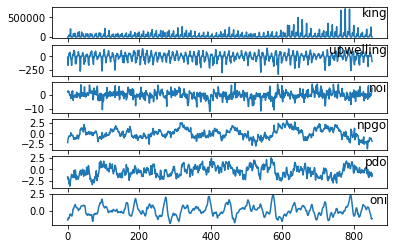

In [178]:
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=.5, loc='right')
    i += 1
plt.show()

<h2>Make Series into Train and Test Set with inputs and ouptuts</h2>

In [179]:
# convert series to supervised learning
# series_to_supervised from Jason Brownlee's "Multivariate Time Series Forecasting in Keras"
def series_to_supervised(data, n_in=6, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_months = 6
n_features = 6
reframed = series_to_supervised(scaled, n_months, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[13]], axis=1, inplace=True)
print(reframed.head())

    var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
6    0.000006   0.520913   0.710488   0.220877   0.329032   0.119048   
7    0.000006   0.079848   0.683284   0.332829   0.238710   0.166667   
8    0.000035   0.399240   0.731936   0.405446   0.283871   0.190476   
9    0.009241   0.566540   0.675895   0.422088   0.267742   0.166667   
10   0.070540   0.764259   0.689713   0.456883   0.074194   0.190476   

    var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  ...  var3(t-1)  var4(t-1)  \
6    0.000006   0.079848   0.683284   0.332829  ...   0.632281   0.464448   
7    0.000035   0.399240   0.731936   0.405446  ...   0.567508   0.440242   
8    0.009241   0.566540   0.675895   0.422088  ...   0.572306   0.468986   
9    0.070540   0.764259   0.689713   0.456883  ...   0.591786   0.461422   
10   0.023221   0.703422   0.632281   0.464448  ...   0.461760   0.570348   

    var5(t-1)  var6(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
6    0.182258   0.238095  

In [180]:
# split into train and test sets
values = reframed.values
n_train_months = 66 * 12 # MENTAL NOTE: IF ERROR IN MOTH TO YEAR CHECK THIS
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
n_obs = n_months * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
train_X = train_X.reshape((train_X.shape[0], n_months, n_features))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(792, 6, 6) (792,) (54, 6, 6) (54,)


In [181]:
X_train, X_dev, y_train, y_dev = train_test_split(train_X, train_y, test_size=0.10, shuffle=False)

In [182]:
print(X_dev.shape)
print(y_dev.shape)
print(X_train.shape)
print(y_train.shape)
print(test_X.shape)
print(test_y.shape)

(80, 6, 6)
(80,)
(712, 6, 6)
(712,)
(54, 6, 6)
(54,)


Epoch 1/5000
1/1 - 5s - loss: 0.0206 - root_mean_squared_error: 0.1437 - val_loss: 0.0488 - val_root_mean_squared_error: 0.2209
Epoch 2/5000
1/1 - 0s - loss: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 0.0453 - val_root_mean_squared_error: 0.2129
Epoch 3/5000
1/1 - 0s - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.0458 - val_root_mean_squared_error: 0.2140
Epoch 4/5000
1/1 - 0s - loss: 0.0153 - root_mean_squared_error: 0.1237 - val_loss: 0.0452 - val_root_mean_squared_error: 0.2126
Epoch 5/5000
1/1 - 0s - loss: 0.0145 - root_mean_squared_error: 0.1206 - val_loss: 0.0444 - val_root_mean_squared_error: 0.2108
Epoch 6/5000
1/1 - 0s - loss: 0.0123 - root_mean_squared_error: 0.1111 - val_loss: 0.0449 - val_root_mean_squared_error: 0.2119
Epoch 7/5000
1/1 - 0s - loss: 0.0108 - root_mean_squared_error: 0.1039 - val_loss: 0.0469 - val_root_mean_squared_error: 0.2167
Epoch 8/5000
1/1 - 0s - loss: 0.0107 - root_mean_squared_error: 0.1037 - val_loss: 0.0494 - val_root_mea

Epoch 40/5000
1/1 - 0s - loss: 0.0085 - root_mean_squared_error: 0.0919 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1977
Epoch 41/5000
1/1 - 0s - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0386 - val_root_mean_squared_error: 0.1965
Epoch 42/5000
1/1 - 0s - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1958
Epoch 43/5000
1/1 - 0s - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1956
Epoch 44/5000
1/1 - 0s - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1959
Epoch 45/5000
1/1 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0913 - val_loss: 0.0386 - val_root_mean_squared_error: 0.1965
Epoch 46/5000
1/1 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 0.0389 - val_root_mean_squared_error: 0.1972
Epoch 47/5000
1/1 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.0391 - val_

Epoch 79/5000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 0.0367 - val_root_mean_squared_error: 0.1915
Epoch 80/5000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 0.0367 - val_root_mean_squared_error: 0.1915
Epoch 81/5000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 0.0366 - val_root_mean_squared_error: 0.1914
Epoch 82/5000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0366 - val_root_mean_squared_error: 0.1912
Epoch 83/5000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1909
Epoch 84/5000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 85/5000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1904
Epoch 86/5000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0362 - val_

Epoch 118/5000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0869 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1885
Epoch 119/5000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0869 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1884
Epoch 120/5000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0869 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1883
Epoch 121/5000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0869 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1882
Epoch 122/5000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0869 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1882
Epoch 123/5000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1882
Epoch 124/5000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1882
Epoch 125/5000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.035

Epoch 157/5000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0863 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1873
Epoch 158/5000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0863 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1873
Epoch 159/5000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0863 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1872
Epoch 160/5000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1872
Epoch 161/5000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1872
Epoch 162/5000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1872
Epoch 163/5000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1872
Epoch 164/5000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.035

Epoch 196/5000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1866
Epoch 197/5000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1866
Epoch 198/5000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1866
Epoch 199/5000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1866
Epoch 200/5000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1866
Epoch 201/5000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1866
Epoch 202/5000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1865
Epoch 203/5000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.034

Epoch 235/5000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1860
Epoch 236/5000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1860
Epoch 237/5000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1860
Epoch 238/5000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1860
Epoch 239/5000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1860
Epoch 240/5000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1860
Epoch 241/5000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1859
Epoch 242/5000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.034

Epoch 274/5000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1854
Epoch 275/5000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1853
Epoch 276/5000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1853
Epoch 277/5000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1853
Epoch 278/5000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1853
Epoch 279/5000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1853
Epoch 280/5000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1852
Epoch 281/5000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.034

Epoch 313/5000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1845
Epoch 314/5000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1845
Epoch 315/5000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1844
Epoch 316/5000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1844
Epoch 317/5000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1844
Epoch 318/5000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1844
Epoch 319/5000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1843
Epoch 320/5000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.034

Epoch 352/5000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1834
Epoch 353/5000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1833
Epoch 354/5000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1833
Epoch 355/5000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1833
Epoch 356/5000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1832
Epoch 357/5000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1832
Epoch 358/5000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1832
Epoch 359/5000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0842 - val_loss: 0.033

Epoch 391/5000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1819
Epoch 392/5000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1818
Epoch 393/5000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0836 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1818
Epoch 394/5000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0836 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1817
Epoch 395/5000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0836 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1817
Epoch 396/5000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0836 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1816
Epoch 397/5000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0836 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1816
Epoch 398/5000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.033

Epoch 430/5000
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0324 - val_root_mean_squared_error: 0.1799
Epoch 431/5000
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1798
Epoch 432/5000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0828 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1798
Epoch 433/5000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1797
Epoch 434/5000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1797
Epoch 435/5000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1796
Epoch 436/5000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0322 - val_root_mean_squared_error: 0.1795
Epoch 437/5000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0826 - val_loss: 0.032

Epoch 469/5000
1/1 - 0s - loss: 0.0067 - root_mean_squared_error: 0.0817 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1774
Epoch 470/5000
1/1 - 0s - loss: 0.0067 - root_mean_squared_error: 0.0817 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1773
Epoch 471/5000
1/1 - 0s - loss: 0.0067 - root_mean_squared_error: 0.0817 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1772
Epoch 472/5000
1/1 - 0s - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1771
Epoch 473/5000
1/1 - 0s - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1771
Epoch 474/5000
1/1 - 0s - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1770
Epoch 475/5000
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1769
Epoch 476/5000
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.031

Epoch 508/5000
1/1 - 0s - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1737
Epoch 509/5000
1/1 - 0s - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1738
Epoch 510/5000
1/1 - 0s - loss: 0.0064 - root_mean_squared_error: 0.0800 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1733
Epoch 511/5000
1/1 - 0s - loss: 0.0064 - root_mean_squared_error: 0.0800 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1739
Epoch 512/5000
1/1 - 0s - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0297 - val_root_mean_squared_error: 0.1723
Epoch 513/5000
1/1 - 0s - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0307 - val_root_mean_squared_error: 0.1752
Epoch 514/5000
1/1 - 0s - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1702
Epoch 515/5000
1/1 - 0s - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.031

Epoch 547/5000
1/1 - 0s - loss: 0.0061 - root_mean_squared_error: 0.0782 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1684
Epoch 548/5000
1/1 - 0s - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0287 - val_root_mean_squared_error: 0.1693
Epoch 549/5000
1/1 - 0s - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1693
Epoch 550/5000
1/1 - 0s - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1680
Epoch 551/5000
1/1 - 0s - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0287 - val_root_mean_squared_error: 0.1693
Epoch 552/5000
1/1 - 0s - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1681
Epoch 553/5000
1/1 - 0s - loss: 0.0061 - root_mean_squared_error: 0.0778 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1682
Epoch 554/5000
1/1 - 0s - loss: 0.0060 - root_mean_squared_error: 0.0777 - val_loss: 0.028

Epoch 586/5000
1/1 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 0.0257 - val_root_mean_squared_error: 0.1604
Epoch 587/5000
1/1 - 0s - loss: 0.0058 - root_mean_squared_error: 0.0760 - val_loss: 0.0277 - val_root_mean_squared_error: 0.1664
Epoch 588/5000
1/1 - 0s - loss: 0.0058 - root_mean_squared_error: 0.0763 - val_loss: 0.0257 - val_root_mean_squared_error: 0.1602
Epoch 589/5000
1/1 - 0s - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0265 - val_root_mean_squared_error: 0.1629
Epoch 590/5000
1/1 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 0.0267 - val_root_mean_squared_error: 0.1635
Epoch 591/5000
1/1 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1595
Epoch 592/5000
1/1 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 0.0270 - val_root_mean_squared_error: 0.1643
Epoch 593/5000
1/1 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0756 - val_loss: 0.025

Epoch 625/5000
1/1 - 0s - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1557
Epoch 626/5000
1/1 - 0s - loss: 0.0053 - root_mean_squared_error: 0.0729 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1549
Epoch 627/5000
1/1 - 0s - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1547
Epoch 628/5000
1/1 - 0s - loss: 0.0053 - root_mean_squared_error: 0.0727 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1550
Epoch 629/5000
1/1 - 0s - loss: 0.0053 - root_mean_squared_error: 0.0727 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1540
Epoch 630/5000
1/1 - 0s - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1546
Epoch 631/5000
1/1 - 0s - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1537
Epoch 632/5000
1/1 - 0s - loss: 0.0052 - root_mean_squared_error: 0.0724 - val_loss: 0.023

Epoch 664/5000
1/1 - 0s - loss: 0.0048 - root_mean_squared_error: 0.0696 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1463
Epoch 665/5000
1/1 - 0s - loss: 0.0048 - root_mean_squared_error: 0.0695 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1459
Epoch 666/5000
1/1 - 0s - loss: 0.0048 - root_mean_squared_error: 0.0694 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1458
Epoch 667/5000
1/1 - 0s - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1454
Epoch 668/5000
1/1 - 0s - loss: 0.0048 - root_mean_squared_error: 0.0692 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1452
Epoch 669/5000
1/1 - 0s - loss: 0.0048 - root_mean_squared_error: 0.0691 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1449
Epoch 670/5000
1/1 - 0s - loss: 0.0048 - root_mean_squared_error: 0.0690 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1446
Epoch 671/5000
1/1 - 0s - loss: 0.0047 - root_mean_squared_error: 0.0689 - val_loss: 0.020

Epoch 703/5000
1/1 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1353
Epoch 704/5000
1/1 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1335
Epoch 705/5000
1/1 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1350
Epoch 706/5000
1/1 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0646 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1325
Epoch 707/5000
1/1 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0645 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1348
Epoch 708/5000
1/1 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0645 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1315
Epoch 709/5000
1/1 - 0s - loss: 0.0041 - root_mean_squared_error: 0.0644 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1346
Epoch 710/5000
1/1 - 0s - loss: 0.0041 - root_mean_squared_error: 0.0643 - val_loss: 0.017

Epoch 742/5000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1212
Epoch 743/5000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0599 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1211
Epoch 744/5000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1208
Epoch 745/5000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1202
Epoch 746/5000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0596 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1204
Epoch 747/5000
1/1 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0595 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1195
Epoch 748/5000
1/1 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0594 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1197
Epoch 749/5000
1/1 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0593 - val_loss: 0.014

Epoch 781/5000
1/1 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0561 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1103
Epoch 782/5000
1/1 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0560 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094
Epoch 783/5000
1/1 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0559 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 784/5000
1/1 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 785/5000
1/1 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 786/5000
1/1 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0557 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1078
Epoch 787/5000
1/1 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0556 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 788/5000
1/1 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0556 - val_loss: 0.011

Epoch 820/5000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0531 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 821/5000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1005
Epoch 822/5000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012
Epoch 823/5000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1003
Epoch 824/5000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1003
Epoch 825/5000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1004
Epoch 826/5000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0527 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996
Epoch 827/5000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0527 - val_loss: 0.010

Epoch 859/5000
1/1 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0509 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0944
Epoch 860/5000
1/1 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0509 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0944
Epoch 861/5000
1/1 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0508 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0942
Epoch 862/5000
1/1 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0508 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0940
Epoch 863/5000
1/1 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0507 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0939
Epoch 864/5000
1/1 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0507 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0937
Epoch 865/5000
1/1 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0506 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0937
Epoch 866/5000
1/1 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0506 - val_loss: 0.008

Epoch 898/5000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0492 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894
Epoch 899/5000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0492 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893
Epoch 900/5000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891
Epoch 901/5000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891
Epoch 902/5000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0889
Epoch 903/5000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888
Epoch 904/5000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 905/5000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.007

Epoch 937/5000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0478 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852
Epoch 938/5000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0851
Epoch 939/5000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850
Epoch 940/5000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849
Epoch 941/5000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0476 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0848
Epoch 942/5000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0476 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0847
Epoch 943/5000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0847
Epoch 944/5000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 0.007

Epoch 976/5000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0831
Epoch 977/5000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0803
Epoch 978/5000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0828
Epoch 979/5000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0464 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0808
Epoch 980/5000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0463 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0815
Epoch 981/5000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0462 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818
Epoch 982/5000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0462 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0804
Epoch 983/5000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0462 - val_loss: 0.006

1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0790
Epoch 1015/5000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0785
Epoch 1016/5000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0788
Epoch 1017/5000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0785
Epoch 1018/5000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0786
Epoch 1019/5000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0785
Epoch 1020/5000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0783
Epoch 1021/5000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0062 - val_

Epoch 1053/5000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0760
Epoch 1054/5000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0760
Epoch 1055/5000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0759
Epoch 1056/5000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0759
Epoch 1057/5000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0757
Epoch 1058/5000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0757
Epoch 1059/5000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0755
Epoch 1060/5000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_los

Epoch 1091/5000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0732
Epoch 1092/5000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0425 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727
Epoch 1093/5000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0747
Epoch 1094/5000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0720
Epoch 1095/5000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0741
Epoch 1096/5000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0425 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0728
Epoch 1097/5000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0726
Epoch 1098/5000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_los

Epoch 1130/5000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0707
Epoch 1131/5000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0709
Epoch 1132/5000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0708
Epoch 1133/5000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0706
Epoch 1134/5000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0708
Epoch 1135/5000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0704
Epoch 1136/5000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0708
Epoch 1137/5000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_los

Epoch 1168/5000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657
Epoch 1169/5000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0414 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0719
Epoch 1170/5000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0670
Epoch 1171/5000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0681
Epoch 1172/5000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0399 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0700
Epoch 1173/5000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0401 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0662
Epoch 1174/5000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0405 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0713
Epoch 1175/5000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0406 - val_los

Epoch 1207/5000
1/1 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657
Epoch 1208/5000
1/1 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0668
Epoch 1209/5000
1/1 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657
Epoch 1210/5000
1/1 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 1211/5000
1/1 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0660
Epoch 1212/5000
1/1 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0658
Epoch 1213/5000
1/1 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0662
Epoch 1214/5000
1/1 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_los

Epoch 1245/5000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0641
Epoch 1246/5000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640
Epoch 1247/5000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0639
Epoch 1248/5000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0639
Epoch 1249/5000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0638
Epoch 1250/5000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0638
Epoch 1251/5000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637
Epoch 1252/5000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_los

Epoch 1284/5000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0642
Epoch 1285/5000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608
Epoch 1286/5000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0622
Epoch 1287/5000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0632
Epoch 1288/5000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608
Epoch 1289/5000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0624
Epoch 1290/5000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0628
Epoch 1291/5000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_los

Epoch 1322/5000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0606
Epoch 1323/5000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601
Epoch 1324/5000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0604
Epoch 1325/5000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0603
Epoch 1326/5000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601
Epoch 1327/5000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0604
Epoch 1328/5000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0362 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601
Epoch 1329/5000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0362 - val_los

Epoch 1361/5000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0587
Epoch 1362/5000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0587
Epoch 1363/5000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587
Epoch 1364/5000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586
Epoch 1365/5000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586
Epoch 1366/5000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586
Epoch 1367/5000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0585
Epoch 1368/5000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_los

Epoch 1399/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573
Epoch 1400/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573
Epoch 1401/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572
Epoch 1402/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572
Epoch 1403/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572
Epoch 1404/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0571
Epoch 1405/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0571
Epoch 1406/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0349 - val_los

Epoch 1438/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0344 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559
Epoch 1439/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0344 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559
Epoch 1440/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0344 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559
Epoch 1441/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0344 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 1442/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0344 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 1443/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0344 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 1444/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 1445/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_los

Epoch 1476/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0338 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0549
Epoch 1477/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0338 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0543
Epoch 1478/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0338 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551
Epoch 1479/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0338 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0539
Epoch 1480/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0338 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 1481/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0339 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0533
Epoch 1482/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0341 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574
Epoch 1483/5000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_los

Epoch 1515/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528
Epoch 1516/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0548
Epoch 1517/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0532
Epoch 1518/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0530
Epoch 1519/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0544
Epoch 1520/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528
Epoch 1521/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0534
Epoch 1522/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_los

Epoch 1553/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0521
Epoch 1554/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0524
Epoch 1555/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0522
Epoch 1556/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0521
Epoch 1557/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523
Epoch 1558/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0521
Epoch 1559/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0521
Epoch 1560/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_los

Epoch 1592/5000
1/1 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0320 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0510
Epoch 1593/5000
1/1 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0320 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0510
Epoch 1594/5000
1/1 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0320 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0509
Epoch 1595/5000
1/1 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0509
Epoch 1596/5000
1/1 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 1597/5000
1/1 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 1598/5000
1/1 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 1599/5000
1/1 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_los

Epoch 1630/5000
1/1 - 0s - loss: 9.8227e-04 - root_mean_squared_error: 0.0313 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0496
Epoch 1631/5000
1/1 - 0s - loss: 9.8116e-04 - root_mean_squared_error: 0.0313 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0496
Epoch 1632/5000
1/1 - 0s - loss: 9.8005e-04 - root_mean_squared_error: 0.0313 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0496
Epoch 1633/5000
1/1 - 0s - loss: 9.7893e-04 - root_mean_squared_error: 0.0313 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0495
Epoch 1634/5000
1/1 - 0s - loss: 9.7782e-04 - root_mean_squared_error: 0.0313 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0495
Epoch 1635/5000
1/1 - 0s - loss: 9.7671e-04 - root_mean_squared_error: 0.0313 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0495
Epoch 1636/5000
1/1 - 0s - loss: 9.7559e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 1637/5000
1/1 - 0s - loss: 9.7448e-04 - root_mean

Epoch 1668/5000
1/1 - 0s - loss: 9.4087e-04 - root_mean_squared_error: 0.0307 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 1669/5000
1/1 - 0s - loss: 9.4071e-04 - root_mean_squared_error: 0.0307 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0487
Epoch 1670/5000
1/1 - 0s - loss: 9.4165e-04 - root_mean_squared_error: 0.0307 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 1671/5000
1/1 - 0s - loss: 9.4444e-04 - root_mean_squared_error: 0.0307 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 1672/5000
1/1 - 0s - loss: 9.5227e-04 - root_mean_squared_error: 0.0309 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0471
Epoch 1673/5000
1/1 - 0s - loss: 9.6688e-04 - root_mean_squared_error: 0.0311 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0509
Epoch 1674/5000
1/1 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0468
Epoch 1675/5000
1/1 - 0s - loss: 0.0011 - root_mean_squared

Epoch 1706/5000
1/1 - 0s - loss: 9.0521e-04 - root_mean_squared_error: 0.0301 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0481
Epoch 1707/5000
1/1 - 0s - loss: 9.1423e-04 - root_mean_squared_error: 0.0302 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0466
Epoch 1708/5000
1/1 - 0s - loss: 9.1719e-04 - root_mean_squared_error: 0.0303 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 1709/5000
1/1 - 0s - loss: 9.0695e-04 - root_mean_squared_error: 0.0301 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 1710/5000
1/1 - 0s - loss: 9.0029e-04 - root_mean_squared_error: 0.0300 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 1711/5000
1/1 - 0s - loss: 9.0547e-04 - root_mean_squared_error: 0.0301 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 1712/5000
1/1 - 0s - loss: 9.0929e-04 - root_mean_squared_error: 0.0302 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0466
Epoch 1713/5000
1/1 - 0s - loss: 9.0209e-04 - root_mean

Epoch 1744/5000
1/1 - 0s - loss: 8.6809e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 1745/5000
1/1 - 0s - loss: 8.6711e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 1746/5000
1/1 - 0s - loss: 8.6595e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0458
Epoch 1747/5000
1/1 - 0s - loss: 8.6486e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0458
Epoch 1748/5000
1/1 - 0s - loss: 8.6399e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0456
Epoch 1749/5000
1/1 - 0s - loss: 8.6321e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0458
Epoch 1750/5000
1/1 - 0s - loss: 8.6233e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0455
Epoch 1751/5000
1/1 - 0s - loss: 8.6131e-04 - root_mean

Epoch 1782/5000
1/1 - 0s - loss: 8.3288e-04 - root_mean_squared_error: 0.0289 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 1783/5000
1/1 - 0s - loss: 8.3198e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 1784/5000
1/1 - 0s - loss: 8.3109e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 1785/5000
1/1 - 0s - loss: 8.3020e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 1786/5000
1/1 - 0s - loss: 8.2931e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 1787/5000
1/1 - 0s - loss: 8.2841e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 1788/5000
1/1 - 0s - loss: 8.2752e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 1789/5000
1/1 - 0s - loss: 8.2663e-04 - root_mean

Epoch 1820/5000
1/1 - 0s - loss: 8.0415e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0430
Epoch 1821/5000
1/1 - 0s - loss: 8.0664e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 1822/5000
1/1 - 0s - loss: 8.1282e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426
Epoch 1823/5000
1/1 - 0s - loss: 8.2255e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0458
Epoch 1824/5000
1/1 - 0s - loss: 8.4596e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0423
Epoch 1825/5000
1/1 - 0s - loss: 8.7300e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0482
Epoch 1826/5000
1/1 - 0s - loss: 9.4114e-04 - root_mean_squared_error: 0.0307 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0423
Epoch 1827/5000
1/1 - 0s - loss: 9.6588e-04 - root_mean

Epoch 1858/5000
1/1 - 0s - loss: 7.7178e-04 - root_mean_squared_error: 0.0278 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 1859/5000
1/1 - 0s - loss: 7.7223e-04 - root_mean_squared_error: 0.0278 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0436
Epoch 1860/5000
1/1 - 0s - loss: 7.7636e-04 - root_mean_squared_error: 0.0279 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420
Epoch 1861/5000
1/1 - 0s - loss: 7.7811e-04 - root_mean_squared_error: 0.0279 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0433
Epoch 1862/5000
1/1 - 0s - loss: 7.7534e-04 - root_mean_squared_error: 0.0278 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424
Epoch 1863/5000
1/1 - 0s - loss: 7.6952e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 1864/5000
1/1 - 0s - loss: 7.6690e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0430
Epoch 1865/5000
1/1 - 0s - loss: 7.6772e-04 - root_mean

Epoch 1896/5000
1/1 - 0s - loss: 7.4365e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 1897/5000
1/1 - 0s - loss: 7.4289e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 1898/5000
1/1 - 0s - loss: 7.4207e-04 - root_mean_squared_error: 0.0272 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0418
Epoch 1899/5000
1/1 - 0s - loss: 7.4124e-04 - root_mean_squared_error: 0.0272 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0417
Epoch 1900/5000
1/1 - 0s - loss: 7.4043e-04 - root_mean_squared_error: 0.0272 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0417
Epoch 1901/5000
1/1 - 0s - loss: 7.3967e-04 - root_mean_squared_error: 0.0272 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0417
Epoch 1902/5000
1/1 - 0s - loss: 7.3895e-04 - root_mean_squared_error: 0.0272 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 1903/5000
1/1 - 0s - loss: 7.3826e-04 - root_mean

Epoch 1934/5000
1/1 - 0s - loss: 7.2834e-04 - root_mean_squared_error: 0.0270 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 1935/5000
1/1 - 0s - loss: 7.3481e-04 - root_mean_squared_error: 0.0271 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 1936/5000
1/1 - 0s - loss: 7.4977e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 1937/5000
1/1 - 0s - loss: 7.6659e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 1938/5000
1/1 - 0s - loss: 8.0778e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 1939/5000
1/1 - 0s - loss: 8.2992e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 1940/5000
1/1 - 0s - loss: 8.9350e-04 - root_mean_squared_error: 0.0299 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 1941/5000
1/1 - 0s - loss: 8.5872e-04 - root_mean

Epoch 1972/5000
1/1 - 0s - loss: 6.9702e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0409
Epoch 1973/5000
1/1 - 0s - loss: 6.9824e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 1974/5000
1/1 - 0s - loss: 6.9684e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407
Epoch 1975/5000
1/1 - 0s - loss: 6.9427e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 1976/5000
1/1 - 0s - loss: 6.9141e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402
Epoch 1977/5000
1/1 - 0s - loss: 6.8974e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402
Epoch 1978/5000
1/1 - 0s - loss: 6.8947e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0398
Epoch 1979/5000
1/1 - 0s - loss: 6.9001e-04 - root_mean

Epoch 2010/5000
1/1 - 0s - loss: 6.6946e-04 - root_mean_squared_error: 0.0259 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 2011/5000
1/1 - 0s - loss: 6.6881e-04 - root_mean_squared_error: 0.0259 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0394
Epoch 2012/5000
1/1 - 0s - loss: 6.6818e-04 - root_mean_squared_error: 0.0258 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 2013/5000
1/1 - 0s - loss: 6.6756e-04 - root_mean_squared_error: 0.0258 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0394
Epoch 2014/5000
1/1 - 0s - loss: 6.6695e-04 - root_mean_squared_error: 0.0258 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 2015/5000
1/1 - 0s - loss: 6.6634e-04 - root_mean_squared_error: 0.0258 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 2016/5000
1/1 - 0s - loss: 6.6575e-04 - root_mean_squared_error: 0.0258 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 2017/5000
1/1 - 0s - loss: 6.6518e-04 - root_mean

Epoch 2048/5000
1/1 - 0s - loss: 6.8041e-04 - root_mean_squared_error: 0.0261 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 2049/5000
1/1 - 0s - loss: 6.7219e-04 - root_mean_squared_error: 0.0259 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0398
Epoch 2050/5000
1/1 - 0s - loss: 6.6039e-04 - root_mean_squared_error: 0.0257 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 2051/5000
1/1 - 0s - loss: 6.4855e-04 - root_mean_squared_error: 0.0255 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 2052/5000
1/1 - 0s - loss: 6.4570e-04 - root_mean_squared_error: 0.0254 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 2053/5000
1/1 - 0s - loss: 6.5073e-04 - root_mean_squared_error: 0.0255 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 2054/5000
1/1 - 0s - loss: 6.5702e-04 - root_mean_squared_error: 0.0256 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0398
Epoch 2055/5000
1/1 - 0s - loss: 6.6078e-04 - root_mean

Epoch 2086/5000
1/1 - 0s - loss: 6.2651e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 2087/5000
1/1 - 0s - loss: 6.2587e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 2088/5000
1/1 - 0s - loss: 6.2534e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 2089/5000
1/1 - 0s - loss: 6.2490e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0376
Epoch 2090/5000
1/1 - 0s - loss: 6.2450e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 2091/5000
1/1 - 0s - loss: 6.2413e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 2092/5000
1/1 - 0s - loss: 6.2375e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 2093/5000
1/1 - 0s - loss: 6.2339e-04 - root_mean

Epoch 2124/5000
1/1 - 0s - loss: 6.3675e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 2125/5000
1/1 - 0s - loss: 6.3392e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 2126/5000
1/1 - 0s - loss: 6.3128e-04 - root_mean_squared_error: 0.0251 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 2127/5000
1/1 - 0s - loss: 6.2118e-04 - root_mean_squared_error: 0.0249 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0380
Epoch 2128/5000
1/1 - 0s - loss: 6.1312e-04 - root_mean_squared_error: 0.0248 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 2129/5000
1/1 - 0s - loss: 6.0649e-04 - root_mean_squared_error: 0.0246 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0371
Epoch 2130/5000
1/1 - 0s - loss: 6.0376e-04 - root_mean_squared_error: 0.0246 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 2131/5000
1/1 - 0s - loss: 6.0452e-04 - root_mean

Epoch 2162/5000
1/1 - 0s - loss: 5.9083e-04 - root_mean_squared_error: 0.0243 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0360
Epoch 2163/5000
1/1 - 0s - loss: 5.9034e-04 - root_mean_squared_error: 0.0243 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 2164/5000
1/1 - 0s - loss: 5.9015e-04 - root_mean_squared_error: 0.0243 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 2165/5000
1/1 - 0s - loss: 5.8993e-04 - root_mean_squared_error: 0.0243 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 2166/5000
1/1 - 0s - loss: 5.9014e-04 - root_mean_squared_error: 0.0243 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0358
Epoch 2167/5000
1/1 - 0s - loss: 5.9036e-04 - root_mean_squared_error: 0.0243 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 2168/5000
1/1 - 0s - loss: 5.9136e-04 - root_mean_squared_error: 0.0243 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0357
Epoch 2169/5000
1/1 - 0s - loss: 5.9242e-04 - root_mean

Epoch 2200/5000
1/1 - 0s - loss: 5.8437e-04 - root_mean_squared_error: 0.0242 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 2201/5000
1/1 - 0s - loss: 5.8140e-04 - root_mean_squared_error: 0.0241 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 2202/5000
1/1 - 0s - loss: 5.7863e-04 - root_mean_squared_error: 0.0241 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 2203/5000
1/1 - 0s - loss: 5.7464e-04 - root_mean_squared_error: 0.0240 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 2204/5000
1/1 - 0s - loss: 5.7154e-04 - root_mean_squared_error: 0.0239 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 2205/5000
1/1 - 0s - loss: 5.6923e-04 - root_mean_squared_error: 0.0239 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0358
Epoch 2206/5000
1/1 - 0s - loss: 5.6806e-04 - root_mean_squared_error: 0.0238 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 2207/5000
1/1 - 0s - loss: 5.6788e-04 - root_mean

Epoch 2238/5000
1/1 - 0s - loss: 5.8512e-04 - root_mean_squared_error: 0.0242 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 2239/5000
1/1 - 0s - loss: 5.9682e-04 - root_mean_squared_error: 0.0244 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 2240/5000
1/1 - 0s - loss: 5.9954e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 2241/5000
1/1 - 0s - loss: 6.1210e-04 - root_mean_squared_error: 0.0247 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 2242/5000
1/1 - 0s - loss: 6.0638e-04 - root_mean_squared_error: 0.0246 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 2243/5000
1/1 - 0s - loss: 6.0945e-04 - root_mean_squared_error: 0.0247 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 2244/5000
1/1 - 0s - loss: 5.9291e-04 - root_mean_squared_error: 0.0243 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 2245/5000
1/1 - 0s - loss: 5.8253e-04 - root_mean

Epoch 2276/5000
1/1 - 0s - loss: 5.4056e-04 - root_mean_squared_error: 0.0232 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
Epoch 2277/5000
1/1 - 0s - loss: 5.3957e-04 - root_mean_squared_error: 0.0232 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 2278/5000
1/1 - 0s - loss: 5.3870e-04 - root_mean_squared_error: 0.0232 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 2279/5000
1/1 - 0s - loss: 5.3800e-04 - root_mean_squared_error: 0.0232 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 2280/5000
1/1 - 0s - loss: 5.3738e-04 - root_mean_squared_error: 0.0232 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 2281/5000
1/1 - 0s - loss: 5.3684e-04 - root_mean_squared_error: 0.0232 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 2282/5000
1/1 - 0s - loss: 5.3634e-04 - root_mean_squared_error: 0.0232 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345
Epoch 2283/5000
1/1 - 0s - loss: 5.3589e-04 - root_mean

Epoch 2314/5000
1/1 - 0s - loss: 5.9883e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 2315/5000
1/1 - 0s - loss: 5.9367e-04 - root_mean_squared_error: 0.0244 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 2316/5000
1/1 - 0s - loss: 5.5216e-04 - root_mean_squared_error: 0.0235 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 2317/5000
1/1 - 0s - loss: 5.2745e-04 - root_mean_squared_error: 0.0230 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345
Epoch 2318/5000
1/1 - 0s - loss: 5.2560e-04 - root_mean_squared_error: 0.0229 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 2319/5000
1/1 - 0s - loss: 5.4119e-04 - root_mean_squared_error: 0.0233 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 2320/5000
1/1 - 0s - loss: 5.5956e-04 - root_mean_squared_error: 0.0237 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 2321/5000
1/1 - 0s - loss: 5.5538e-04 - root_mean

Epoch 2352/5000
1/1 - 0s - loss: 5.1191e-04 - root_mean_squared_error: 0.0226 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0332
Epoch 2353/5000
1/1 - 0s - loss: 5.1075e-04 - root_mean_squared_error: 0.0226 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0335
Epoch 2354/5000
1/1 - 0s - loss: 5.0986e-04 - root_mean_squared_error: 0.0226 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 2355/5000
1/1 - 0s - loss: 5.0934e-04 - root_mean_squared_error: 0.0226 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 2356/5000
1/1 - 0s - loss: 5.0913e-04 - root_mean_squared_error: 0.0226 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 2357/5000
1/1 - 0s - loss: 5.0911e-04 - root_mean_squared_error: 0.0226 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 2358/5000
1/1 - 0s - loss: 5.0909e-04 - root_mean_squared_error: 0.0226 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 2359/5000
1/1 - 0s - loss: 5.0901e-04 - root_mean

Epoch 2390/5000
1/1 - 0s - loss: 5.1337e-04 - root_mean_squared_error: 0.0227 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 2391/5000
1/1 - 0s - loss: 5.1780e-04 - root_mean_squared_error: 0.0228 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 2392/5000
1/1 - 0s - loss: 5.2792e-04 - root_mean_squared_error: 0.0230 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 2393/5000
1/1 - 0s - loss: 5.3430e-04 - root_mean_squared_error: 0.0231 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 2394/5000
1/1 - 0s - loss: 5.5112e-04 - root_mean_squared_error: 0.0235 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 2395/5000
1/1 - 0s - loss: 5.5432e-04 - root_mean_squared_error: 0.0235 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 2396/5000
1/1 - 0s - loss: 5.7087e-04 - root_mean_squared_error: 0.0239 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0316
Epoch 2397/5000
1/1 - 0s - loss: 5.5925e-04 - root_mean

Epoch 2428/5000
1/1 - 0s - loss: 4.8760e-04 - root_mean_squared_error: 0.0221 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0330
Epoch 2429/5000
1/1 - 0s - loss: 4.8890e-04 - root_mean_squared_error: 0.0221 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 2430/5000
1/1 - 0s - loss: 4.8968e-04 - root_mean_squared_error: 0.0221 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 2431/5000
1/1 - 0s - loss: 4.9071e-04 - root_mean_squared_error: 0.0222 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 2432/5000
1/1 - 0s - loss: 4.9069e-04 - root_mean_squared_error: 0.0222 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 2433/5000
1/1 - 0s - loss: 4.9100e-04 - root_mean_squared_error: 0.0222 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 2434/5000
1/1 - 0s - loss: 4.9006e-04 - root_mean_squared_error: 0.0221 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 2435/5000
1/1 - 0s - loss: 4.8954e-04 - root_mean

1/1 - 0s - loss: 5.5217e-04 - root_mean_squared_error: 0.0235 - val_loss: 9.4600e-04 - val_root_mean_squared_error: 0.0308
Epoch 2466/5000
1/1 - 0s - loss: 5.2071e-04 - root_mean_squared_error: 0.0228 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0337
Epoch 2467/5000
1/1 - 0s - loss: 4.9936e-04 - root_mean_squared_error: 0.0223 - val_loss: 9.7955e-04 - val_root_mean_squared_error: 0.0313
Epoch 2468/5000
1/1 - 0s - loss: 4.7903e-04 - root_mean_squared_error: 0.0219 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 2469/5000
1/1 - 0s - loss: 4.7158e-04 - root_mean_squared_error: 0.0217 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0325
Epoch 2470/5000
1/1 - 0s - loss: 4.7535e-04 - root_mean_squared_error: 0.0218 - val_loss: 9.6803e-04 - val_root_mean_squared_error: 0.0311
Epoch 2471/5000
1/1 - 0s - loss: 4.8549e-04 - root_mean_squared_error: 0.0220 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 2472/5000
1/1 - 0s - loss: 4.9912e-04 - root_mean_squ

Epoch 2503/5000
1/1 - 0s - loss: 4.6089e-04 - root_mean_squared_error: 0.0215 - val_loss: 9.7762e-04 - val_root_mean_squared_error: 0.0313
Epoch 2504/5000
1/1 - 0s - loss: 4.6060e-04 - root_mean_squared_error: 0.0215 - val_loss: 9.8855e-04 - val_root_mean_squared_error: 0.0314
Epoch 2505/5000
1/1 - 0s - loss: 4.6055e-04 - root_mean_squared_error: 0.0215 - val_loss: 9.6605e-04 - val_root_mean_squared_error: 0.0311
Epoch 2506/5000
1/1 - 0s - loss: 4.6065e-04 - root_mean_squared_error: 0.0215 - val_loss: 9.9612e-04 - val_root_mean_squared_error: 0.0316
Epoch 2507/5000
1/1 - 0s - loss: 4.6086e-04 - root_mean_squared_error: 0.0215 - val_loss: 9.5712e-04 - val_root_mean_squared_error: 0.0309
Epoch 2508/5000
1/1 - 0s - loss: 4.6108e-04 - root_mean_squared_error: 0.0215 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 2509/5000
1/1 - 0s - loss: 4.6141e-04 - root_mean_squared_error: 0.0215 - val_loss: 9.4994e-04 - val_root_mean_squared_error: 0.0308
Epoch 2510/5000
1/1 - 0s - loss

Epoch 2540/5000
1/1 - 0s - loss: 4.5804e-04 - root_mean_squared_error: 0.0214 - val_loss: 9.1187e-04 - val_root_mean_squared_error: 0.0302
Epoch 2541/5000
1/1 - 0s - loss: 4.5964e-04 - root_mean_squared_error: 0.0214 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 2542/5000
1/1 - 0s - loss: 4.6223e-04 - root_mean_squared_error: 0.0215 - val_loss: 9.0426e-04 - val_root_mean_squared_error: 0.0301
Epoch 2543/5000
1/1 - 0s - loss: 4.6302e-04 - root_mean_squared_error: 0.0215 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0321
Epoch 2544/5000
1/1 - 0s - loss: 4.6530e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.9950e-04 - val_root_mean_squared_error: 0.0300
Epoch 2545/5000
1/1 - 0s - loss: 4.6489e-04 - root_mean_squared_error: 0.0216 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0321
Epoch 2546/5000
1/1 - 0s - loss: 4.6634e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.9734e-04 - val_root_mean_squared_error: 0.0300
Epoch 2547/5000
1/1 - 0s - loss: 4.6470

1/1 - 0s - loss: 4.5298e-04 - root_mean_squared_error: 0.0213 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 2578/5000
1/1 - 0s - loss: 4.6205e-04 - root_mean_squared_error: 0.0215 - val_loss: 8.6091e-04 - val_root_mean_squared_error: 0.0293
Epoch 2579/5000
1/1 - 0s - loss: 4.7192e-04 - root_mean_squared_error: 0.0217 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0330
Epoch 2580/5000
1/1 - 0s - loss: 4.9497e-04 - root_mean_squared_error: 0.0222 - val_loss: 8.5492e-04 - val_root_mean_squared_error: 0.0292
Epoch 2581/5000
1/1 - 0s - loss: 5.1072e-04 - root_mean_squared_error: 0.0226 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 2582/5000
1/1 - 0s - loss: 5.5320e-04 - root_mean_squared_error: 0.0235 - val_loss: 8.5794e-04 - val_root_mean_squared_error: 0.0293
Epoch 2583/5000
1/1 - 0s - loss: 5.5157e-04 - root_mean_squared_error: 0.0235 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0354
Epoch 2584/5000
1/1 - 0s - loss: 5.7566e-04 - root_mean_squ

Epoch 2615/5000
1/1 - 0s - loss: 4.3398e-04 - root_mean_squared_error: 0.0208 - val_loss: 9.3176e-04 - val_root_mean_squared_error: 0.0305
Epoch 2616/5000
1/1 - 0s - loss: 4.3520e-04 - root_mean_squared_error: 0.0209 - val_loss: 8.5950e-04 - val_root_mean_squared_error: 0.0293
Epoch 2617/5000
1/1 - 0s - loss: 4.3493e-04 - root_mean_squared_error: 0.0209 - val_loss: 9.2783e-04 - val_root_mean_squared_error: 0.0305
Epoch 2618/5000
1/1 - 0s - loss: 4.3414e-04 - root_mean_squared_error: 0.0208 - val_loss: 8.6236e-04 - val_root_mean_squared_error: 0.0294
Epoch 2619/5000
1/1 - 0s - loss: 4.3231e-04 - root_mean_squared_error: 0.0208 - val_loss: 9.0979e-04 - val_root_mean_squared_error: 0.0302
Epoch 2620/5000
1/1 - 0s - loss: 4.3057e-04 - root_mean_squared_error: 0.0208 - val_loss: 8.7269e-04 - val_root_mean_squared_error: 0.0295
Epoch 2621/5000
1/1 - 0s - loss: 4.2900e-04 - root_mean_squared_error: 0.0207 - val_loss: 8.9022e-04 - val_root_mean_squared_error: 0.0298
Epoch 2622/5000
1/1 - 0s - 

Epoch 2652/5000
1/1 - 0s - loss: 4.2302e-04 - root_mean_squared_error: 0.0206 - val_loss: 8.3177e-04 - val_root_mean_squared_error: 0.0288
Epoch 2653/5000
1/1 - 0s - loss: 4.2391e-04 - root_mean_squared_error: 0.0206 - val_loss: 8.9937e-04 - val_root_mean_squared_error: 0.0300
Epoch 2654/5000
1/1 - 0s - loss: 4.2572e-04 - root_mean_squared_error: 0.0206 - val_loss: 8.2148e-04 - val_root_mean_squared_error: 0.0287
Epoch 2655/5000
1/1 - 0s - loss: 4.2792e-04 - root_mean_squared_error: 0.0207 - val_loss: 9.2247e-04 - val_root_mean_squared_error: 0.0304
Epoch 2656/5000
1/1 - 0s - loss: 4.3241e-04 - root_mean_squared_error: 0.0208 - val_loss: 8.0994e-04 - val_root_mean_squared_error: 0.0285
Epoch 2657/5000
1/1 - 0s - loss: 4.3720e-04 - root_mean_squared_error: 0.0209 - val_loss: 9.6280e-04 - val_root_mean_squared_error: 0.0310
Epoch 2658/5000
1/1 - 0s - loss: 4.4761e-04 - root_mean_squared_error: 0.0212 - val_loss: 8.0021e-04 - val_root_mean_squared_error: 0.0283
Epoch 2659/5000
1/1 - 0s - 

Epoch 2689/5000
1/1 - 0s - loss: 4.1277e-04 - root_mean_squared_error: 0.0203 - val_loss: 8.1021e-04 - val_root_mean_squared_error: 0.0285
Epoch 2690/5000
1/1 - 0s - loss: 4.1472e-04 - root_mean_squared_error: 0.0204 - val_loss: 8.7502e-04 - val_root_mean_squared_error: 0.0296
Epoch 2691/5000
1/1 - 0s - loss: 4.1695e-04 - root_mean_squared_error: 0.0204 - val_loss: 8.0131e-04 - val_root_mean_squared_error: 0.0283
Epoch 2692/5000
1/1 - 0s - loss: 4.1799e-04 - root_mean_squared_error: 0.0204 - val_loss: 8.8181e-04 - val_root_mean_squared_error: 0.0297
Epoch 2693/5000
1/1 - 0s - loss: 4.1882e-04 - root_mean_squared_error: 0.0205 - val_loss: 7.9836e-04 - val_root_mean_squared_error: 0.0283
Epoch 2694/5000
1/1 - 0s - loss: 4.1784e-04 - root_mean_squared_error: 0.0204 - val_loss: 8.7448e-04 - val_root_mean_squared_error: 0.0296
Epoch 2695/5000
1/1 - 0s - loss: 4.1687e-04 - root_mean_squared_error: 0.0204 - val_loss: 8.0023e-04 - val_root_mean_squared_error: 0.0283
Epoch 2696/5000
1/1 - 0s - 

Epoch 2726/5000
1/1 - 0s - loss: 4.2772e-04 - root_mean_squared_error: 0.0207 - val_loss: 7.5719e-04 - val_root_mean_squared_error: 0.0275
Epoch 2727/5000
1/1 - 0s - loss: 4.2859e-04 - root_mean_squared_error: 0.0207 - val_loss: 9.1675e-04 - val_root_mean_squared_error: 0.0303
Epoch 2728/5000
1/1 - 0s - loss: 4.3413e-04 - root_mean_squared_error: 0.0208 - val_loss: 7.5412e-04 - val_root_mean_squared_error: 0.0275
Epoch 2729/5000
1/1 - 0s - loss: 4.3290e-04 - root_mean_squared_error: 0.0208 - val_loss: 9.2264e-04 - val_root_mean_squared_error: 0.0304
Epoch 2730/5000
1/1 - 0s - loss: 4.3660e-04 - root_mean_squared_error: 0.0209 - val_loss: 7.5327e-04 - val_root_mean_squared_error: 0.0274
Epoch 2731/5000
1/1 - 0s - loss: 4.3170e-04 - root_mean_squared_error: 0.0208 - val_loss: 9.1009e-04 - val_root_mean_squared_error: 0.0302
Epoch 2732/5000
1/1 - 0s - loss: 4.3097e-04 - root_mean_squared_error: 0.0208 - val_loss: 7.5599e-04 - val_root_mean_squared_error: 0.0275
Epoch 2733/5000
1/1 - 0s - 

Epoch 2763/5000
1/1 - 0s - loss: 3.9618e-04 - root_mean_squared_error: 0.0199 - val_loss: 7.6373e-04 - val_root_mean_squared_error: 0.0276
Epoch 2764/5000
1/1 - 0s - loss: 3.9515e-04 - root_mean_squared_error: 0.0199 - val_loss: 7.9154e-04 - val_root_mean_squared_error: 0.0281
Epoch 2765/5000
1/1 - 0s - loss: 3.9441e-04 - root_mean_squared_error: 0.0199 - val_loss: 7.6712e-04 - val_root_mean_squared_error: 0.0277
Epoch 2766/5000
1/1 - 0s - loss: 3.9381e-04 - root_mean_squared_error: 0.0198 - val_loss: 7.8354e-04 - val_root_mean_squared_error: 0.0280
Epoch 2767/5000
1/1 - 0s - loss: 3.9334e-04 - root_mean_squared_error: 0.0198 - val_loss: 7.6924e-04 - val_root_mean_squared_error: 0.0277
Epoch 2768/5000
1/1 - 0s - loss: 3.9296e-04 - root_mean_squared_error: 0.0198 - val_loss: 7.7748e-04 - val_root_mean_squared_error: 0.0279
Epoch 2769/5000
1/1 - 0s - loss: 3.9265e-04 - root_mean_squared_error: 0.0198 - val_loss: 7.7030e-04 - val_root_mean_squared_error: 0.0278
Epoch 2770/5000
1/1 - 0s - 

Epoch 2800/5000
1/1 - 0s - loss: 4.4706e-04 - root_mean_squared_error: 0.0211 - val_loss: 9.5565e-04 - val_root_mean_squared_error: 0.0309
Epoch 2801/5000
1/1 - 0s - loss: 4.6214e-04 - root_mean_squared_error: 0.0215 - val_loss: 7.2098e-04 - val_root_mean_squared_error: 0.0269
Epoch 2802/5000
1/1 - 0s - loss: 4.3375e-04 - root_mean_squared_error: 0.0208 - val_loss: 8.5129e-04 - val_root_mean_squared_error: 0.0292
Epoch 2803/5000
1/1 - 0s - loss: 4.0970e-04 - root_mean_squared_error: 0.0202 - val_loss: 7.3887e-04 - val_root_mean_squared_error: 0.0272
Epoch 2804/5000
1/1 - 0s - loss: 3.8938e-04 - root_mean_squared_error: 0.0197 - val_loss: 7.4755e-04 - val_root_mean_squared_error: 0.0273
Epoch 2805/5000
1/1 - 0s - loss: 3.8714e-04 - root_mean_squared_error: 0.0197 - val_loss: 8.2185e-04 - val_root_mean_squared_error: 0.0287
Epoch 2806/5000
1/1 - 0s - loss: 3.9893e-04 - root_mean_squared_error: 0.0200 - val_loss: 7.1420e-04 - val_root_mean_squared_error: 0.0267
Epoch 2807/5000
1/1 - 0s - 

Epoch 2837/5000
1/1 - 0s - loss: 3.7889e-04 - root_mean_squared_error: 0.0195 - val_loss: 7.2028e-04 - val_root_mean_squared_error: 0.0268
Epoch 2838/5000
1/1 - 0s - loss: 3.7821e-04 - root_mean_squared_error: 0.0194 - val_loss: 7.2325e-04 - val_root_mean_squared_error: 0.0269
Epoch 2839/5000
1/1 - 0s - loss: 3.7789e-04 - root_mean_squared_error: 0.0194 - val_loss: 7.2894e-04 - val_root_mean_squared_error: 0.0270
Epoch 2840/5000
1/1 - 0s - loss: 3.7785e-04 - root_mean_squared_error: 0.0194 - val_loss: 7.1358e-04 - val_root_mean_squared_error: 0.0267
Epoch 2841/5000
1/1 - 0s - loss: 3.7797e-04 - root_mean_squared_error: 0.0194 - val_loss: 7.3510e-04 - val_root_mean_squared_error: 0.0271
Epoch 2842/5000
1/1 - 0s - loss: 3.7815e-04 - root_mean_squared_error: 0.0194 - val_loss: 7.0831e-04 - val_root_mean_squared_error: 0.0266
Epoch 2843/5000
1/1 - 0s - loss: 3.7824e-04 - root_mean_squared_error: 0.0194 - val_loss: 7.3743e-04 - val_root_mean_squared_error: 0.0272
Epoch 2844/5000
1/1 - 0s - 

Epoch 2874/5000
1/1 - 0s - loss: 3.7550e-04 - root_mean_squared_error: 0.0194 - val_loss: 7.4211e-04 - val_root_mean_squared_error: 0.0272
Epoch 2875/5000
1/1 - 0s - loss: 3.7824e-04 - root_mean_squared_error: 0.0194 - val_loss: 6.6589e-04 - val_root_mean_squared_error: 0.0258
Epoch 2876/5000
1/1 - 0s - loss: 3.8170e-04 - root_mean_squared_error: 0.0195 - val_loss: 7.7210e-04 - val_root_mean_squared_error: 0.0278
Epoch 2877/5000
1/1 - 0s - loss: 3.8890e-04 - root_mean_squared_error: 0.0197 - val_loss: 6.5690e-04 - val_root_mean_squared_error: 0.0256
Epoch 2878/5000
1/1 - 0s - loss: 3.9664e-04 - root_mean_squared_error: 0.0199 - val_loss: 8.2758e-04 - val_root_mean_squared_error: 0.0288
Epoch 2879/5000
1/1 - 0s - loss: 4.1401e-04 - root_mean_squared_error: 0.0203 - val_loss: 6.5458e-04 - val_root_mean_squared_error: 0.0256
Epoch 2880/5000
1/1 - 0s - loss: 4.2672e-04 - root_mean_squared_error: 0.0207 - val_loss: 9.1331e-04 - val_root_mean_squared_error: 0.0302
Epoch 2881/5000
1/1 - 0s - 

Epoch 2911/5000
1/1 - 0s - loss: 3.7119e-04 - root_mean_squared_error: 0.0193 - val_loss: 7.1270e-04 - val_root_mean_squared_error: 0.0267
Epoch 2912/5000
1/1 - 0s - loss: 3.6885e-04 - root_mean_squared_error: 0.0192 - val_loss: 6.5939e-04 - val_root_mean_squared_error: 0.0257
Epoch 2913/5000
1/1 - 0s - loss: 3.6600e-04 - root_mean_squared_error: 0.0191 - val_loss: 6.8974e-04 - val_root_mean_squared_error: 0.0263
Epoch 2914/5000
1/1 - 0s - loss: 3.6398e-04 - root_mean_squared_error: 0.0191 - val_loss: 6.7133e-04 - val_root_mean_squared_error: 0.0259
Epoch 2915/5000
1/1 - 0s - loss: 3.6287e-04 - root_mean_squared_error: 0.0190 - val_loss: 6.6983e-04 - val_root_mean_squared_error: 0.0259
Epoch 2916/5000
1/1 - 0s - loss: 3.6271e-04 - root_mean_squared_error: 0.0190 - val_loss: 6.8529e-04 - val_root_mean_squared_error: 0.0262
Epoch 2917/5000
1/1 - 0s - loss: 3.6322e-04 - root_mean_squared_error: 0.0191 - val_loss: 6.5759e-04 - val_root_mean_squared_error: 0.0256
Epoch 2918/5000
1/1 - 0s - 

Epoch 2948/5000
1/1 - 0s - loss: 3.7068e-04 - root_mean_squared_error: 0.0193 - val_loss: 6.1789e-04 - val_root_mean_squared_error: 0.0249
Epoch 2949/5000
1/1 - 0s - loss: 3.7336e-04 - root_mean_squared_error: 0.0193 - val_loss: 7.3476e-04 - val_root_mean_squared_error: 0.0271
Epoch 2950/5000
1/1 - 0s - loss: 3.7961e-04 - root_mean_squared_error: 0.0195 - val_loss: 6.1367e-04 - val_root_mean_squared_error: 0.0248
Epoch 2951/5000
1/1 - 0s - loss: 3.8306e-04 - root_mean_squared_error: 0.0196 - val_loss: 7.6295e-04 - val_root_mean_squared_error: 0.0276
Epoch 2952/5000
1/1 - 0s - loss: 3.9237e-04 - root_mean_squared_error: 0.0198 - val_loss: 6.1151e-04 - val_root_mean_squared_error: 0.0247
Epoch 2953/5000
1/1 - 0s - loss: 3.9455e-04 - root_mean_squared_error: 0.0199 - val_loss: 7.8820e-04 - val_root_mean_squared_error: 0.0281
Epoch 2954/5000
1/1 - 0s - loss: 4.0449e-04 - root_mean_squared_error: 0.0201 - val_loss: 6.1040e-04 - val_root_mean_squared_error: 0.0247
Epoch 2955/5000
1/1 - 0s - 

Epoch 2985/5000
1/1 - 0s - loss: 3.5760e-04 - root_mean_squared_error: 0.0189 - val_loss: 6.7825e-04 - val_root_mean_squared_error: 0.0260
Epoch 2986/5000
1/1 - 0s - loss: 3.5941e-04 - root_mean_squared_error: 0.0190 - val_loss: 6.0105e-04 - val_root_mean_squared_error: 0.0245
Epoch 2987/5000
1/1 - 0s - loss: 3.6018e-04 - root_mean_squared_error: 0.0190 - val_loss: 6.8588e-04 - val_root_mean_squared_error: 0.0262
Epoch 2988/5000
1/1 - 0s - loss: 3.6227e-04 - root_mean_squared_error: 0.0190 - val_loss: 5.9756e-04 - val_root_mean_squared_error: 0.0244
Epoch 2989/5000
1/1 - 0s - loss: 3.6272e-04 - root_mean_squared_error: 0.0190 - val_loss: 6.9226e-04 - val_root_mean_squared_error: 0.0263
Epoch 2990/5000
1/1 - 0s - loss: 3.6490e-04 - root_mean_squared_error: 0.0191 - val_loss: 5.9498e-04 - val_root_mean_squared_error: 0.0244
Epoch 2991/5000
1/1 - 0s - loss: 3.6468e-04 - root_mean_squared_error: 0.0191 - val_loss: 6.9583e-04 - val_root_mean_squared_error: 0.0264
Epoch 2992/5000
1/1 - 0s - 

Epoch 3022/5000
1/1 - 0s - loss: 3.7457e-04 - root_mean_squared_error: 0.0194 - val_loss: 5.7316e-04 - val_root_mean_squared_error: 0.0239
Epoch 3023/5000
1/1 - 0s - loss: 3.8191e-04 - root_mean_squared_error: 0.0195 - val_loss: 7.5785e-04 - val_root_mean_squared_error: 0.0275
Epoch 3024/5000
1/1 - 0s - loss: 4.0032e-04 - root_mean_squared_error: 0.0200 - val_loss: 5.7508e-04 - val_root_mean_squared_error: 0.0240
Epoch 3025/5000
1/1 - 0s - loss: 4.0514e-04 - root_mean_squared_error: 0.0201 - val_loss: 8.0373e-04 - val_root_mean_squared_error: 0.0284
Epoch 3026/5000
1/1 - 0s - loss: 4.2472e-04 - root_mean_squared_error: 0.0206 - val_loss: 5.7493e-04 - val_root_mean_squared_error: 0.0240
Epoch 3027/5000
1/1 - 0s - loss: 4.1365e-04 - root_mean_squared_error: 0.0203 - val_loss: 7.8780e-04 - val_root_mean_squared_error: 0.0281
Epoch 3028/5000
1/1 - 0s - loss: 4.1385e-04 - root_mean_squared_error: 0.0203 - val_loss: 5.6934e-04 - val_root_mean_squared_error: 0.0239
Epoch 3029/5000
1/1 - 0s - 

Epoch 3059/5000
1/1 - 0s - loss: 3.4185e-04 - root_mean_squared_error: 0.0185 - val_loss: 5.6526e-04 - val_root_mean_squared_error: 0.0238
Epoch 3060/5000
1/1 - 0s - loss: 3.4266e-04 - root_mean_squared_error: 0.0185 - val_loss: 6.2501e-04 - val_root_mean_squared_error: 0.0250
Epoch 3061/5000
1/1 - 0s - loss: 3.4358e-04 - root_mean_squared_error: 0.0185 - val_loss: 5.6222e-04 - val_root_mean_squared_error: 0.0237
Epoch 3062/5000
1/1 - 0s - loss: 3.4327e-04 - root_mean_squared_error: 0.0185 - val_loss: 6.2326e-04 - val_root_mean_squared_error: 0.0250
Epoch 3063/5000
1/1 - 0s - loss: 3.4311e-04 - root_mean_squared_error: 0.0185 - val_loss: 5.6247e-04 - val_root_mean_squared_error: 0.0237
Epoch 3064/5000
1/1 - 0s - loss: 3.4184e-04 - root_mean_squared_error: 0.0185 - val_loss: 6.1644e-04 - val_root_mean_squared_error: 0.0248
Epoch 3065/5000
1/1 - 0s - loss: 3.4088e-04 - root_mean_squared_error: 0.0185 - val_loss: 5.6505e-04 - val_root_mean_squared_error: 0.0238
Epoch 3066/5000
1/1 - 0s - 

Epoch 3096/5000
1/1 - 0s - loss: 4.3339e-04 - root_mean_squared_error: 0.0208 - val_loss: 5.4611e-04 - val_root_mean_squared_error: 0.0234
Epoch 3097/5000
1/1 - 0s - loss: 4.2176e-04 - root_mean_squared_error: 0.0205 - val_loss: 7.8822e-04 - val_root_mean_squared_error: 0.0281
Epoch 3098/5000
1/1 - 0s - loss: 4.2538e-04 - root_mean_squared_error: 0.0206 - val_loss: 5.3404e-04 - val_root_mean_squared_error: 0.0231
Epoch 3099/5000
1/1 - 0s - loss: 3.8662e-04 - root_mean_squared_error: 0.0197 - val_loss: 6.6831e-04 - val_root_mean_squared_error: 0.0259
Epoch 3100/5000
1/1 - 0s - loss: 3.6025e-04 - root_mean_squared_error: 0.0190 - val_loss: 5.4766e-04 - val_root_mean_squared_error: 0.0234
Epoch 3101/5000
1/1 - 0s - loss: 3.3655e-04 - root_mean_squared_error: 0.0183 - val_loss: 5.6921e-04 - val_root_mean_squared_error: 0.0239
Epoch 3102/5000
1/1 - 0s - loss: 3.2970e-04 - root_mean_squared_error: 0.0182 - val_loss: 6.1352e-04 - val_root_mean_squared_error: 0.0248
Epoch 3103/5000
1/1 - 0s - 

Epoch 3133/5000
1/1 - 0s - loss: 3.2393e-04 - root_mean_squared_error: 0.0180 - val_loss: 5.5660e-04 - val_root_mean_squared_error: 0.0236
Epoch 3134/5000
1/1 - 0s - loss: 3.2426e-04 - root_mean_squared_error: 0.0180 - val_loss: 5.3656e-04 - val_root_mean_squared_error: 0.0232
Epoch 3135/5000
1/1 - 0s - loss: 3.2486e-04 - root_mean_squared_error: 0.0180 - val_loss: 5.6520e-04 - val_root_mean_squared_error: 0.0238
Epoch 3136/5000
1/1 - 0s - loss: 3.2557e-04 - root_mean_squared_error: 0.0180 - val_loss: 5.3126e-04 - val_root_mean_squared_error: 0.0230
Epoch 3137/5000
1/1 - 0s - loss: 3.2605e-04 - root_mean_squared_error: 0.0181 - val_loss: 5.6890e-04 - val_root_mean_squared_error: 0.0239
Epoch 3138/5000
1/1 - 0s - loss: 3.2648e-04 - root_mean_squared_error: 0.0181 - val_loss: 5.2779e-04 - val_root_mean_squared_error: 0.0230
Epoch 3139/5000
1/1 - 0s - loss: 3.2646e-04 - root_mean_squared_error: 0.0181 - val_loss: 5.6833e-04 - val_root_mean_squared_error: 0.0238
Epoch 3140/5000
1/1 - 0s - 

Epoch 3170/5000
1/1 - 0s - loss: 3.2635e-04 - root_mean_squared_error: 0.0181 - val_loss: 5.0229e-04 - val_root_mean_squared_error: 0.0224
Epoch 3171/5000
1/1 - 0s - loss: 3.3056e-04 - root_mean_squared_error: 0.0182 - val_loss: 6.0018e-04 - val_root_mean_squared_error: 0.0245
Epoch 3172/5000
1/1 - 0s - loss: 3.3931e-04 - root_mean_squared_error: 0.0184 - val_loss: 4.9867e-04 - val_root_mean_squared_error: 0.0223
Epoch 3173/5000
1/1 - 0s - loss: 3.4887e-04 - root_mean_squared_error: 0.0187 - val_loss: 6.6173e-04 - val_root_mean_squared_error: 0.0257
Epoch 3174/5000
1/1 - 0s - loss: 3.7048e-04 - root_mean_squared_error: 0.0192 - val_loss: 5.0576e-04 - val_root_mean_squared_error: 0.0225
Epoch 3175/5000
1/1 - 0s - loss: 3.8588e-04 - root_mean_squared_error: 0.0196 - val_loss: 7.5805e-04 - val_root_mean_squared_error: 0.0275
Epoch 3176/5000
1/1 - 0s - loss: 4.2563e-04 - root_mean_squared_error: 0.0206 - val_loss: 5.1916e-04 - val_root_mean_squared_error: 0.0228
Epoch 3177/5000
1/1 - 0s - 

Epoch 3207/5000
1/1 - 0s - loss: 3.1268e-04 - root_mean_squared_error: 0.0177 - val_loss: 5.1239e-04 - val_root_mean_squared_error: 0.0226
Epoch 3208/5000
1/1 - 0s - loss: 3.1187e-04 - root_mean_squared_error: 0.0177 - val_loss: 5.0283e-04 - val_root_mean_squared_error: 0.0224
Epoch 3209/5000
1/1 - 0s - loss: 3.1238e-04 - root_mean_squared_error: 0.0177 - val_loss: 5.2695e-04 - val_root_mean_squared_error: 0.0230
Epoch 3210/5000
1/1 - 0s - loss: 3.1365e-04 - root_mean_squared_error: 0.0177 - val_loss: 4.9343e-04 - val_root_mean_squared_error: 0.0222
Epoch 3211/5000
1/1 - 0s - loss: 3.1483e-04 - root_mean_squared_error: 0.0177 - val_loss: 5.3484e-04 - val_root_mean_squared_error: 0.0231
Epoch 3212/5000
1/1 - 0s - loss: 3.1570e-04 - root_mean_squared_error: 0.0178 - val_loss: 4.9120e-04 - val_root_mean_squared_error: 0.0222
Epoch 3213/5000
1/1 - 0s - loss: 3.1546e-04 - root_mean_squared_error: 0.0178 - val_loss: 5.3202e-04 - val_root_mean_squared_error: 0.0231
Epoch 3214/5000
1/1 - 0s - 

Epoch 3244/5000
1/1 - 0s - loss: 3.0602e-04 - root_mean_squared_error: 0.0175 - val_loss: 4.9443e-04 - val_root_mean_squared_error: 0.0222
Epoch 3245/5000
1/1 - 0s - loss: 3.0586e-04 - root_mean_squared_error: 0.0175 - val_loss: 4.8952e-04 - val_root_mean_squared_error: 0.0221
Epoch 3246/5000
1/1 - 0s - loss: 3.0571e-04 - root_mean_squared_error: 0.0175 - val_loss: 4.9393e-04 - val_root_mean_squared_error: 0.0222
Epoch 3247/5000
1/1 - 0s - loss: 3.0556e-04 - root_mean_squared_error: 0.0175 - val_loss: 4.8809e-04 - val_root_mean_squared_error: 0.0221
Epoch 3248/5000
1/1 - 0s - loss: 3.0541e-04 - root_mean_squared_error: 0.0175 - val_loss: 4.9381e-04 - val_root_mean_squared_error: 0.0222
Epoch 3249/5000
1/1 - 0s - loss: 3.0528e-04 - root_mean_squared_error: 0.0175 - val_loss: 4.8623e-04 - val_root_mean_squared_error: 0.0221
Epoch 3250/5000
1/1 - 0s - loss: 3.0516e-04 - root_mean_squared_error: 0.0175 - val_loss: 4.9433e-04 - val_root_mean_squared_error: 0.0222
Epoch 3251/5000
1/1 - 0s - 

Epoch 3281/5000
1/1 - 0s - loss: 3.2458e-04 - root_mean_squared_error: 0.0180 - val_loss: 4.5894e-04 - val_root_mean_squared_error: 0.0214
Epoch 3282/5000
1/1 - 0s - loss: 3.2971e-04 - root_mean_squared_error: 0.0182 - val_loss: 5.7049e-04 - val_root_mean_squared_error: 0.0239
Epoch 3283/5000
1/1 - 0s - loss: 3.2969e-04 - root_mean_squared_error: 0.0182 - val_loss: 4.5888e-04 - val_root_mean_squared_error: 0.0214
Epoch 3284/5000
1/1 - 0s - loss: 3.1719e-04 - root_mean_squared_error: 0.0178 - val_loss: 5.1308e-04 - val_root_mean_squared_error: 0.0227
Epoch 3285/5000
1/1 - 0s - loss: 3.0670e-04 - root_mean_squared_error: 0.0175 - val_loss: 4.7492e-04 - val_root_mean_squared_error: 0.0218
Epoch 3286/5000
1/1 - 0s - loss: 3.0053e-04 - root_mean_squared_error: 0.0173 - val_loss: 4.6826e-04 - val_root_mean_squared_error: 0.0216
Epoch 3287/5000
1/1 - 0s - loss: 3.0145e-04 - root_mean_squared_error: 0.0174 - val_loss: 5.1122e-04 - val_root_mean_squared_error: 0.0226
Epoch 3288/5000
1/1 - 0s - 

Epoch 3318/5000
1/1 - 0s - loss: 2.9571e-04 - root_mean_squared_error: 0.0172 - val_loss: 4.7063e-04 - val_root_mean_squared_error: 0.0217
Epoch 3319/5000
1/1 - 0s - loss: 2.9583e-04 - root_mean_squared_error: 0.0172 - val_loss: 4.4973e-04 - val_root_mean_squared_error: 0.0212
Epoch 3320/5000
1/1 - 0s - loss: 2.9584e-04 - root_mean_squared_error: 0.0172 - val_loss: 4.7126e-04 - val_root_mean_squared_error: 0.0217
Epoch 3321/5000
1/1 - 0s - loss: 2.9581e-04 - root_mean_squared_error: 0.0172 - val_loss: 4.4844e-04 - val_root_mean_squared_error: 0.0212
Epoch 3322/5000
1/1 - 0s - loss: 2.9563e-04 - root_mean_squared_error: 0.0172 - val_loss: 4.7001e-04 - val_root_mean_squared_error: 0.0217
Epoch 3323/5000
1/1 - 0s - loss: 2.9544e-04 - root_mean_squared_error: 0.0172 - val_loss: 4.4828e-04 - val_root_mean_squared_error: 0.0212
Epoch 3324/5000
1/1 - 0s - loss: 2.9514e-04 - root_mean_squared_error: 0.0172 - val_loss: 4.6798e-04 - val_root_mean_squared_error: 0.0216
Epoch 3325/5000
1/1 - 0s - 

Epoch 3355/5000
1/1 - 0s - loss: 3.4056e-04 - root_mean_squared_error: 0.0185 - val_loss: 4.3240e-04 - val_root_mean_squared_error: 0.0208
Epoch 3356/5000
1/1 - 0s - loss: 3.5476e-04 - root_mean_squared_error: 0.0188 - val_loss: 6.5736e-04 - val_root_mean_squared_error: 0.0256
Epoch 3357/5000
1/1 - 0s - loss: 3.9061e-04 - root_mean_squared_error: 0.0198 - val_loss: 4.4683e-04 - val_root_mean_squared_error: 0.0211
Epoch 3358/5000
1/1 - 0s - loss: 3.9325e-04 - root_mean_squared_error: 0.0198 - val_loss: 7.0797e-04 - val_root_mean_squared_error: 0.0266
Epoch 3359/5000
1/1 - 0s - loss: 4.1813e-04 - root_mean_squared_error: 0.0204 - val_loss: 4.3529e-04 - val_root_mean_squared_error: 0.0209
Epoch 3360/5000
1/1 - 0s - loss: 3.8013e-04 - root_mean_squared_error: 0.0195 - val_loss: 6.0742e-04 - val_root_mean_squared_error: 0.0246
Epoch 3361/5000
1/1 - 0s - loss: 3.5489e-04 - root_mean_squared_error: 0.0188 - val_loss: 4.1971e-04 - val_root_mean_squared_error: 0.0205
Epoch 3362/5000
1/1 - 0s - 

Epoch 3392/5000
1/1 - 0s - loss: 2.8561e-04 - root_mean_squared_error: 0.0169 - val_loss: 4.4819e-04 - val_root_mean_squared_error: 0.0212
Epoch 3393/5000
1/1 - 0s - loss: 2.8677e-04 - root_mean_squared_error: 0.0169 - val_loss: 4.1623e-04 - val_root_mean_squared_error: 0.0204
Epoch 3394/5000
1/1 - 0s - loss: 2.8753e-04 - root_mean_squared_error: 0.0170 - val_loss: 4.5283e-04 - val_root_mean_squared_error: 0.0213
Epoch 3395/5000
1/1 - 0s - loss: 2.8795e-04 - root_mean_squared_error: 0.0170 - val_loss: 4.1565e-04 - val_root_mean_squared_error: 0.0204
Epoch 3396/5000
1/1 - 0s - loss: 2.8748e-04 - root_mean_squared_error: 0.0170 - val_loss: 4.4915e-04 - val_root_mean_squared_error: 0.0212
Epoch 3397/5000
1/1 - 0s - loss: 2.8677e-04 - root_mean_squared_error: 0.0169 - val_loss: 4.1699e-04 - val_root_mean_squared_error: 0.0204
Epoch 3398/5000
1/1 - 0s - loss: 2.8562e-04 - root_mean_squared_error: 0.0169 - val_loss: 4.4038e-04 - val_root_mean_squared_error: 0.0210
Epoch 3399/5000
1/1 - 0s - 

Epoch 3429/5000
1/1 - 0s - loss: 2.8829e-04 - root_mean_squared_error: 0.0170 - val_loss: 4.6406e-04 - val_root_mean_squared_error: 0.0215
Epoch 3430/5000
1/1 - 0s - loss: 2.9188e-04 - root_mean_squared_error: 0.0171 - val_loss: 3.9477e-04 - val_root_mean_squared_error: 0.0199
Epoch 3431/5000
1/1 - 0s - loss: 2.9507e-04 - root_mean_squared_error: 0.0172 - val_loss: 4.8600e-04 - val_root_mean_squared_error: 0.0220
Epoch 3432/5000
1/1 - 0s - loss: 3.0183e-04 - root_mean_squared_error: 0.0174 - val_loss: 3.9432e-04 - val_root_mean_squared_error: 0.0199
Epoch 3433/5000
1/1 - 0s - loss: 3.0663e-04 - root_mean_squared_error: 0.0175 - val_loss: 5.1774e-04 - val_root_mean_squared_error: 0.0228
Epoch 3434/5000
1/1 - 0s - loss: 3.1792e-04 - root_mean_squared_error: 0.0178 - val_loss: 3.9704e-04 - val_root_mean_squared_error: 0.0199
Epoch 3435/5000
1/1 - 0s - loss: 3.2254e-04 - root_mean_squared_error: 0.0180 - val_loss: 5.5254e-04 - val_root_mean_squared_error: 0.0235
Epoch 3436/5000
1/1 - 0s - 

Epoch 3466/5000
1/1 - 0s - loss: 2.8433e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.8459e-04 - val_root_mean_squared_error: 0.0196
Epoch 3467/5000
1/1 - 0s - loss: 2.8220e-04 - root_mean_squared_error: 0.0168 - val_loss: 4.3467e-04 - val_root_mean_squared_error: 0.0208
Epoch 3468/5000
1/1 - 0s - loss: 2.8070e-04 - root_mean_squared_error: 0.0168 - val_loss: 3.8651e-04 - val_root_mean_squared_error: 0.0197
Epoch 3469/5000
1/1 - 0s - loss: 2.7858e-04 - root_mean_squared_error: 0.0167 - val_loss: 4.2331e-04 - val_root_mean_squared_error: 0.0206
Epoch 3470/5000
1/1 - 0s - loss: 2.7699e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.8976e-04 - val_root_mean_squared_error: 0.0197
Epoch 3471/5000
1/1 - 0s - loss: 2.7542e-04 - root_mean_squared_error: 0.0166 - val_loss: 4.1266e-04 - val_root_mean_squared_error: 0.0203
Epoch 3472/5000
1/1 - 0s - loss: 2.7427e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.9396e-04 - val_root_mean_squared_error: 0.0198
Epoch 3473/5000
1/1 - 0s - 

Epoch 3503/5000
1/1 - 0s - loss: 2.6938e-04 - root_mean_squared_error: 0.0164 - val_loss: 4.1730e-04 - val_root_mean_squared_error: 0.0204
Epoch 3504/5000
1/1 - 0s - loss: 2.7289e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.7632e-04 - val_root_mean_squared_error: 0.0194
Epoch 3505/5000
1/1 - 0s - loss: 2.7815e-04 - root_mean_squared_error: 0.0167 - val_loss: 4.4518e-04 - val_root_mean_squared_error: 0.0211
Epoch 3506/5000
1/1 - 0s - loss: 2.8488e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.7262e-04 - val_root_mean_squared_error: 0.0193
Epoch 3507/5000
1/1 - 0s - loss: 2.8858e-04 - root_mean_squared_error: 0.0170 - val_loss: 4.6149e-04 - val_root_mean_squared_error: 0.0215
Epoch 3508/5000
1/1 - 0s - loss: 2.9335e-04 - root_mean_squared_error: 0.0171 - val_loss: 3.6992e-04 - val_root_mean_squared_error: 0.0192
Epoch 3509/5000
1/1 - 0s - loss: 2.9165e-04 - root_mean_squared_error: 0.0171 - val_loss: 4.5739e-04 - val_root_mean_squared_error: 0.0214
Epoch 3510/5000
1/1 - 0s - 

Epoch 3540/5000
1/1 - 0s - loss: 2.6370e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.7267e-04 - val_root_mean_squared_error: 0.0193
Epoch 3541/5000
1/1 - 0s - loss: 2.6363e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.7974e-04 - val_root_mean_squared_error: 0.0195
Epoch 3542/5000
1/1 - 0s - loss: 2.6361e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.6966e-04 - val_root_mean_squared_error: 0.0192
Epoch 3543/5000
1/1 - 0s - loss: 2.6363e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.8192e-04 - val_root_mean_squared_error: 0.0195
Epoch 3544/5000
1/1 - 0s - loss: 2.6371e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.6674e-04 - val_root_mean_squared_error: 0.0192
Epoch 3545/5000
1/1 - 0s - loss: 2.6384e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.8511e-04 - val_root_mean_squared_error: 0.0196
Epoch 3546/5000
1/1 - 0s - loss: 2.6411e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.6347e-04 - val_root_mean_squared_error: 0.0191
Epoch 3547/5000
1/1 - 0s - 

Epoch 3577/5000
1/1 - 0s - loss: 2.7761e-04 - root_mean_squared_error: 0.0167 - val_loss: 4.3152e-04 - val_root_mean_squared_error: 0.0208
Epoch 3578/5000
1/1 - 0s - loss: 2.8047e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.4732e-04 - val_root_mean_squared_error: 0.0186
Epoch 3579/5000
1/1 - 0s - loss: 2.7593e-04 - root_mean_squared_error: 0.0166 - val_loss: 4.0831e-04 - val_root_mean_squared_error: 0.0202
Epoch 3580/5000
1/1 - 0s - loss: 2.7096e-04 - root_mean_squared_error: 0.0165 - val_loss: 3.4796e-04 - val_root_mean_squared_error: 0.0187
Epoch 3581/5000
1/1 - 0s - loss: 2.6425e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.7450e-04 - val_root_mean_squared_error: 0.0194
Epoch 3582/5000
1/1 - 0s - loss: 2.5990e-04 - root_mean_squared_error: 0.0161 - val_loss: 3.6274e-04 - val_root_mean_squared_error: 0.0190
Epoch 3583/5000
1/1 - 0s - loss: 2.5829e-04 - root_mean_squared_error: 0.0161 - val_loss: 3.5392e-04 - val_root_mean_squared_error: 0.0188
Epoch 3584/5000
1/1 - 0s - 

Epoch 3614/5000
1/1 - 0s - loss: 2.5398e-04 - root_mean_squared_error: 0.0159 - val_loss: 3.5355e-04 - val_root_mean_squared_error: 0.0188
Epoch 3615/5000
1/1 - 0s - loss: 2.5388e-04 - root_mean_squared_error: 0.0159 - val_loss: 3.4832e-04 - val_root_mean_squared_error: 0.0187
Epoch 3616/5000
1/1 - 0s - loss: 2.5382e-04 - root_mean_squared_error: 0.0159 - val_loss: 3.5513e-04 - val_root_mean_squared_error: 0.0188
Epoch 3617/5000
1/1 - 0s - loss: 2.5377e-04 - root_mean_squared_error: 0.0159 - val_loss: 3.4605e-04 - val_root_mean_squared_error: 0.0186
Epoch 3618/5000
1/1 - 0s - loss: 2.5374e-04 - root_mean_squared_error: 0.0159 - val_loss: 3.5657e-04 - val_root_mean_squared_error: 0.0189
Epoch 3619/5000
1/1 - 0s - loss: 2.5375e-04 - root_mean_squared_error: 0.0159 - val_loss: 3.4350e-04 - val_root_mean_squared_error: 0.0185
Epoch 3620/5000
1/1 - 0s - loss: 2.5380e-04 - root_mean_squared_error: 0.0159 - val_loss: 3.5847e-04 - val_root_mean_squared_error: 0.0189
Epoch 3621/5000
1/1 - 0s - 

Epoch 3651/5000
1/1 - 0s - loss: 2.4970e-04 - root_mean_squared_error: 0.0158 - val_loss: 3.3374e-04 - val_root_mean_squared_error: 0.0183
Epoch 3652/5000
1/1 - 0s - loss: 2.5121e-04 - root_mean_squared_error: 0.0158 - val_loss: 3.7533e-04 - val_root_mean_squared_error: 0.0194
Epoch 3653/5000
1/1 - 0s - loss: 2.5673e-04 - root_mean_squared_error: 0.0160 - val_loss: 3.2626e-04 - val_root_mean_squared_error: 0.0181
Epoch 3654/5000
1/1 - 0s - loss: 2.6222e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.9860e-04 - val_root_mean_squared_error: 0.0200
Epoch 3655/5000
1/1 - 0s - loss: 2.6716e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.2401e-04 - val_root_mean_squared_error: 0.0180
Epoch 3656/5000
1/1 - 0s - loss: 2.6641e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.9109e-04 - val_root_mean_squared_error: 0.0198
Epoch 3657/5000
1/1 - 0s - loss: 2.6466e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.2178e-04 - val_root_mean_squared_error: 0.0179
Epoch 3658/5000
1/1 - 0s - 

Epoch 3688/5000
1/1 - 0s - loss: 2.4861e-04 - root_mean_squared_error: 0.0158 - val_loss: 3.5012e-04 - val_root_mean_squared_error: 0.0187
Epoch 3689/5000
1/1 - 0s - loss: 2.4860e-04 - root_mean_squared_error: 0.0158 - val_loss: 3.1560e-04 - val_root_mean_squared_error: 0.0178
Epoch 3690/5000
1/1 - 0s - loss: 2.4839e-04 - root_mean_squared_error: 0.0158 - val_loss: 3.5023e-04 - val_root_mean_squared_error: 0.0187
Epoch 3691/5000
1/1 - 0s - loss: 2.4851e-04 - root_mean_squared_error: 0.0158 - val_loss: 3.1516e-04 - val_root_mean_squared_error: 0.0178
Epoch 3692/5000
1/1 - 0s - loss: 2.4846e-04 - root_mean_squared_error: 0.0158 - val_loss: 3.5176e-04 - val_root_mean_squared_error: 0.0188
Epoch 3693/5000
1/1 - 0s - loss: 2.4883e-04 - root_mean_squared_error: 0.0158 - val_loss: 3.1422e-04 - val_root_mean_squared_error: 0.0177
Epoch 3694/5000
1/1 - 0s - loss: 2.4905e-04 - root_mean_squared_error: 0.0158 - val_loss: 3.5495e-04 - val_root_mean_squared_error: 0.0188
Epoch 3695/5000
1/1 - 0s - 

Epoch 3725/5000
1/1 - 0s - loss: 2.5735e-04 - root_mean_squared_error: 0.0160 - val_loss: 3.7360e-04 - val_root_mean_squared_error: 0.0193
Epoch 3726/5000
1/1 - 0s - loss: 2.5747e-04 - root_mean_squared_error: 0.0160 - val_loss: 3.0103e-04 - val_root_mean_squared_error: 0.0174
Epoch 3727/5000
1/1 - 0s - loss: 2.5469e-04 - root_mean_squared_error: 0.0160 - val_loss: 3.6397e-04 - val_root_mean_squared_error: 0.0191
Epoch 3728/5000
1/1 - 0s - loss: 2.5311e-04 - root_mean_squared_error: 0.0159 - val_loss: 3.0124e-04 - val_root_mean_squared_error: 0.0174
Epoch 3729/5000
1/1 - 0s - loss: 2.4981e-04 - root_mean_squared_error: 0.0158 - val_loss: 3.5053e-04 - val_root_mean_squared_error: 0.0187
Epoch 3730/5000
1/1 - 0s - loss: 2.4756e-04 - root_mean_squared_error: 0.0157 - val_loss: 3.0321e-04 - val_root_mean_squared_error: 0.0174
Epoch 3731/5000
1/1 - 0s - loss: 2.4484e-04 - root_mean_squared_error: 0.0156 - val_loss: 3.3766e-04 - val_root_mean_squared_error: 0.0184
Epoch 3732/5000
1/1 - 0s - 

Epoch 3762/5000
1/1 - 0s - loss: 2.4489e-04 - root_mean_squared_error: 0.0156 - val_loss: 3.1771e-04 - val_root_mean_squared_error: 0.0178
Epoch 3763/5000
1/1 - 0s - loss: 2.3614e-04 - root_mean_squared_error: 0.0154 - val_loss: 3.3279e-04 - val_root_mean_squared_error: 0.0182
Epoch 3764/5000
1/1 - 0s - loss: 2.3860e-04 - root_mean_squared_error: 0.0154 - val_loss: 2.9793e-04 - val_root_mean_squared_error: 0.0173
Epoch 3765/5000
1/1 - 0s - loss: 2.4819e-04 - root_mean_squared_error: 0.0158 - val_loss: 3.8195e-04 - val_root_mean_squared_error: 0.0195
Epoch 3766/5000
1/1 - 0s - loss: 2.6174e-04 - root_mean_squared_error: 0.0162 - val_loss: 2.9962e-04 - val_root_mean_squared_error: 0.0173
Epoch 3767/5000
1/1 - 0s - loss: 2.6883e-04 - root_mean_squared_error: 0.0164 - val_loss: 4.0272e-04 - val_root_mean_squared_error: 0.0201
Epoch 3768/5000
1/1 - 0s - loss: 2.7640e-04 - root_mean_squared_error: 0.0166 - val_loss: 2.9551e-04 - val_root_mean_squared_error: 0.0172
Epoch 3769/5000
1/1 - 0s - 

Epoch 3799/5000
1/1 - 0s - loss: 2.3084e-04 - root_mean_squared_error: 0.0152 - val_loss: 2.9342e-04 - val_root_mean_squared_error: 0.0171
Epoch 3800/5000
1/1 - 0s - loss: 2.3087e-04 - root_mean_squared_error: 0.0152 - val_loss: 3.0173e-04 - val_root_mean_squared_error: 0.0174
Epoch 3801/5000
1/1 - 0s - loss: 2.3101e-04 - root_mean_squared_error: 0.0152 - val_loss: 2.8968e-04 - val_root_mean_squared_error: 0.0170
Epoch 3802/5000
1/1 - 0s - loss: 2.3122e-04 - root_mean_squared_error: 0.0152 - val_loss: 3.0553e-04 - val_root_mean_squared_error: 0.0175
Epoch 3803/5000
1/1 - 0s - loss: 2.3150e-04 - root_mean_squared_error: 0.0152 - val_loss: 2.8730e-04 - val_root_mean_squared_error: 0.0170
Epoch 3804/5000
1/1 - 0s - loss: 2.3178e-04 - root_mean_squared_error: 0.0152 - val_loss: 3.0901e-04 - val_root_mean_squared_error: 0.0176
Epoch 3805/5000
1/1 - 0s - loss: 2.3215e-04 - root_mean_squared_error: 0.0152 - val_loss: 2.8522e-04 - val_root_mean_squared_error: 0.0169
Epoch 3806/5000
1/1 - 0s - 

Epoch 3836/5000
1/1 - 0s - loss: 2.4373e-04 - root_mean_squared_error: 0.0156 - val_loss: 2.7244e-04 - val_root_mean_squared_error: 0.0165
Epoch 3837/5000
1/1 - 0s - loss: 2.4430e-04 - root_mean_squared_error: 0.0156 - val_loss: 3.4513e-04 - val_root_mean_squared_error: 0.0186
Epoch 3838/5000
1/1 - 0s - loss: 2.4599e-04 - root_mean_squared_error: 0.0157 - val_loss: 2.7156e-04 - val_root_mean_squared_error: 0.0165
Epoch 3839/5000
1/1 - 0s - loss: 2.4404e-04 - root_mean_squared_error: 0.0156 - val_loss: 3.4026e-04 - val_root_mean_squared_error: 0.0184
Epoch 3840/5000
1/1 - 0s - loss: 2.4320e-04 - root_mean_squared_error: 0.0156 - val_loss: 2.7090e-04 - val_root_mean_squared_error: 0.0165
Epoch 3841/5000
1/1 - 0s - loss: 2.3956e-04 - root_mean_squared_error: 0.0155 - val_loss: 3.2659e-04 - val_root_mean_squared_error: 0.0181
Epoch 3842/5000
1/1 - 0s - loss: 2.3699e-04 - root_mean_squared_error: 0.0154 - val_loss: 2.7169e-04 - val_root_mean_squared_error: 0.0165
Epoch 3843/5000
1/1 - 0s - 

Epoch 3873/5000
1/1 - 0s - loss: 2.3405e-04 - root_mean_squared_error: 0.0153 - val_loss: 2.6902e-04 - val_root_mean_squared_error: 0.0164
Epoch 3874/5000
1/1 - 0s - loss: 2.2574e-04 - root_mean_squared_error: 0.0150 - val_loss: 2.8463e-04 - val_root_mean_squared_error: 0.0169
Epoch 3875/5000
1/1 - 0s - loss: 2.2218e-04 - root_mean_squared_error: 0.0149 - val_loss: 2.8872e-04 - val_root_mean_squared_error: 0.0170
Epoch 3876/5000
1/1 - 0s - loss: 2.2257e-04 - root_mean_squared_error: 0.0149 - val_loss: 2.6891e-04 - val_root_mean_squared_error: 0.0164
Epoch 3877/5000
1/1 - 0s - loss: 2.2573e-04 - root_mean_squared_error: 0.0150 - val_loss: 3.1227e-04 - val_root_mean_squared_error: 0.0177
Epoch 3878/5000
1/1 - 0s - loss: 2.3071e-04 - root_mean_squared_error: 0.0152 - val_loss: 2.6431e-04 - val_root_mean_squared_error: 0.0163
Epoch 3879/5000
1/1 - 0s - loss: 2.3524e-04 - root_mean_squared_error: 0.0153 - val_loss: 3.3103e-04 - val_root_mean_squared_error: 0.0182
Epoch 3880/5000
1/1 - 0s - 

Epoch 3910/5000
1/1 - 0s - loss: 2.2257e-04 - root_mean_squared_error: 0.0149 - val_loss: 2.8982e-04 - val_root_mean_squared_error: 0.0170
Epoch 3911/5000
1/1 - 0s - loss: 2.2208e-04 - root_mean_squared_error: 0.0149 - val_loss: 2.5687e-04 - val_root_mean_squared_error: 0.0160
Epoch 3912/5000
1/1 - 0s - loss: 2.2146e-04 - root_mean_squared_error: 0.0149 - val_loss: 2.8738e-04 - val_root_mean_squared_error: 0.0170
Epoch 3913/5000
1/1 - 0s - loss: 2.2122e-04 - root_mean_squared_error: 0.0149 - val_loss: 2.5658e-04 - val_root_mean_squared_error: 0.0160
Epoch 3914/5000
1/1 - 0s - loss: 2.2089e-04 - root_mean_squared_error: 0.0149 - val_loss: 2.8663e-04 - val_root_mean_squared_error: 0.0169
Epoch 3915/5000
1/1 - 0s - loss: 2.2089e-04 - root_mean_squared_error: 0.0149 - val_loss: 2.5593e-04 - val_root_mean_squared_error: 0.0160
Epoch 3916/5000
1/1 - 0s - loss: 2.2082e-04 - root_mean_squared_error: 0.0149 - val_loss: 2.8762e-04 - val_root_mean_squared_error: 0.0170
Epoch 3917/5000
1/1 - 0s - 

Epoch 3947/5000
1/1 - 0s - loss: 2.2417e-04 - root_mean_squared_error: 0.0150 - val_loss: 2.8530e-04 - val_root_mean_squared_error: 0.0169
Epoch 3948/5000
1/1 - 0s - loss: 2.1887e-04 - root_mean_squared_error: 0.0148 - val_loss: 2.5223e-04 - val_root_mean_squared_error: 0.0159
Epoch 3949/5000
1/1 - 0s - loss: 2.1501e-04 - root_mean_squared_error: 0.0147 - val_loss: 2.6254e-04 - val_root_mean_squared_error: 0.0162
Epoch 3950/5000
1/1 - 0s - loss: 2.1334e-04 - root_mean_squared_error: 0.0146 - val_loss: 2.6491e-04 - val_root_mean_squared_error: 0.0163
Epoch 3951/5000
1/1 - 0s - loss: 2.1354e-04 - root_mean_squared_error: 0.0146 - val_loss: 2.5010e-04 - val_root_mean_squared_error: 0.0158
Epoch 3952/5000
1/1 - 0s - loss: 2.1504e-04 - root_mean_squared_error: 0.0147 - val_loss: 2.7921e-04 - val_root_mean_squared_error: 0.0167
Epoch 3953/5000
1/1 - 0s - loss: 2.1739e-04 - root_mean_squared_error: 0.0147 - val_loss: 2.4544e-04 - val_root_mean_squared_error: 0.0157
Epoch 3954/5000
1/1 - 0s - 

Epoch 3984/5000
1/1 - 0s - loss: 2.3761e-04 - root_mean_squared_error: 0.0154 - val_loss: 2.4340e-04 - val_root_mean_squared_error: 0.0156
Epoch 3985/5000
1/1 - 0s - loss: 2.4403e-04 - root_mean_squared_error: 0.0156 - val_loss: 3.6052e-04 - val_root_mean_squared_error: 0.0190
Epoch 3986/5000
1/1 - 0s - loss: 2.5801e-04 - root_mean_squared_error: 0.0161 - val_loss: 2.5213e-04 - val_root_mean_squared_error: 0.0159
Epoch 3987/5000
1/1 - 0s - loss: 2.6404e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.9926e-04 - val_root_mean_squared_error: 0.0200
Epoch 3988/5000
1/1 - 0s - loss: 2.8011e-04 - root_mean_squared_error: 0.0167 - val_loss: 2.5704e-04 - val_root_mean_squared_error: 0.0160
Epoch 3989/5000
1/1 - 0s - loss: 2.7671e-04 - root_mean_squared_error: 0.0166 - val_loss: 4.0406e-04 - val_root_mean_squared_error: 0.0201
Epoch 3990/5000
1/1 - 0s - loss: 2.8113e-04 - root_mean_squared_error: 0.0168 - val_loss: 2.4680e-04 - val_root_mean_squared_error: 0.0157
Epoch 3991/5000
1/1 - 0s - 

Epoch 4021/5000
1/1 - 0s - loss: 2.0521e-04 - root_mean_squared_error: 0.0143 - val_loss: 2.3901e-04 - val_root_mean_squared_error: 0.0155
Epoch 4022/5000
1/1 - 0s - loss: 2.0538e-04 - root_mean_squared_error: 0.0143 - val_loss: 2.5039e-04 - val_root_mean_squared_error: 0.0158
Epoch 4023/5000
1/1 - 0s - loss: 2.0591e-04 - root_mean_squared_error: 0.0143 - val_loss: 2.3459e-04 - val_root_mean_squared_error: 0.0153
Epoch 4024/5000
1/1 - 0s - loss: 2.0660e-04 - root_mean_squared_error: 0.0144 - val_loss: 2.5679e-04 - val_root_mean_squared_error: 0.0160
Epoch 4025/5000
1/1 - 0s - loss: 2.0741e-04 - root_mean_squared_error: 0.0144 - val_loss: 2.3203e-04 - val_root_mean_squared_error: 0.0152
Epoch 4026/5000
1/1 - 0s - loss: 2.0810e-04 - root_mean_squared_error: 0.0144 - val_loss: 2.6157e-04 - val_root_mean_squared_error: 0.0162
Epoch 4027/5000
1/1 - 0s - loss: 2.0894e-04 - root_mean_squared_error: 0.0145 - val_loss: 2.3003e-04 - val_root_mean_squared_error: 0.0152
Epoch 4028/5000
1/1 - 0s - 

Epoch 4058/5000
1/1 - 0s - loss: 2.0307e-04 - root_mean_squared_error: 0.0143 - val_loss: 2.4469e-04 - val_root_mean_squared_error: 0.0156
Epoch 4059/5000
1/1 - 0s - loss: 2.0210e-04 - root_mean_squared_error: 0.0142 - val_loss: 2.3044e-04 - val_root_mean_squared_error: 0.0152
Epoch 4060/5000
1/1 - 0s - loss: 2.0139e-04 - root_mean_squared_error: 0.0142 - val_loss: 2.3839e-04 - val_root_mean_squared_error: 0.0154
Epoch 4061/5000
1/1 - 0s - loss: 2.0094e-04 - root_mean_squared_error: 0.0142 - val_loss: 2.3311e-04 - val_root_mean_squared_error: 0.0153
Epoch 4062/5000
1/1 - 0s - loss: 2.0066e-04 - root_mean_squared_error: 0.0142 - val_loss: 2.3396e-04 - val_root_mean_squared_error: 0.0153
Epoch 4063/5000
1/1 - 0s - loss: 2.0051e-04 - root_mean_squared_error: 0.0142 - val_loss: 2.3559e-04 - val_root_mean_squared_error: 0.0153
Epoch 4064/5000
1/1 - 0s - loss: 2.0045e-04 - root_mean_squared_error: 0.0142 - val_loss: 2.3063e-04 - val_root_mean_squared_error: 0.0152
Epoch 4065/5000
1/1 - 0s - 

Epoch 4095/5000
1/1 - 0s - loss: 2.1149e-04 - root_mean_squared_error: 0.0145 - val_loss: 2.2245e-04 - val_root_mean_squared_error: 0.0149
Epoch 4096/5000
1/1 - 0s - loss: 2.0139e-04 - root_mean_squared_error: 0.0142 - val_loss: 2.2596e-04 - val_root_mean_squared_error: 0.0150
Epoch 4097/5000
1/1 - 0s - loss: 1.9856e-04 - root_mean_squared_error: 0.0141 - val_loss: 2.5241e-04 - val_root_mean_squared_error: 0.0159
Epoch 4098/5000
1/1 - 0s - loss: 2.0215e-04 - root_mean_squared_error: 0.0142 - val_loss: 2.1555e-04 - val_root_mean_squared_error: 0.0147
Epoch 4099/5000
1/1 - 0s - loss: 2.0869e-04 - root_mean_squared_error: 0.0144 - val_loss: 2.7512e-04 - val_root_mean_squared_error: 0.0166
Epoch 4100/5000
1/1 - 0s - loss: 2.1579e-04 - root_mean_squared_error: 0.0147 - val_loss: 2.1336e-04 - val_root_mean_squared_error: 0.0146
Epoch 4101/5000
1/1 - 0s - loss: 2.1640e-04 - root_mean_squared_error: 0.0147 - val_loss: 2.7149e-04 - val_root_mean_squared_error: 0.0165
Epoch 4102/5000
1/1 - 0s - 

Epoch 4132/5000
1/1 - 0s - loss: 1.9427e-04 - root_mean_squared_error: 0.0139 - val_loss: 2.1542e-04 - val_root_mean_squared_error: 0.0147
Epoch 4133/5000
1/1 - 0s - loss: 1.9389e-04 - root_mean_squared_error: 0.0139 - val_loss: 2.2535e-04 - val_root_mean_squared_error: 0.0150
Epoch 4134/5000
1/1 - 0s - loss: 1.9356e-04 - root_mean_squared_error: 0.0139 - val_loss: 2.1660e-04 - val_root_mean_squared_error: 0.0147
Epoch 4135/5000
1/1 - 0s - loss: 1.9327e-04 - root_mean_squared_error: 0.0139 - val_loss: 2.2336e-04 - val_root_mean_squared_error: 0.0149
Epoch 4136/5000
1/1 - 0s - loss: 1.9306e-04 - root_mean_squared_error: 0.0139 - val_loss: 2.1759e-04 - val_root_mean_squared_error: 0.0148
Epoch 4137/5000
1/1 - 0s - loss: 1.9291e-04 - root_mean_squared_error: 0.0139 - val_loss: 2.2200e-04 - val_root_mean_squared_error: 0.0149
Epoch 4138/5000
1/1 - 0s - loss: 1.9278e-04 - root_mean_squared_error: 0.0139 - val_loss: 2.1794e-04 - val_root_mean_squared_error: 0.0148
Epoch 4139/5000
1/1 - 0s - 

Epoch 4169/5000
1/1 - 0s - loss: 3.7435e-04 - root_mean_squared_error: 0.0193 - val_loss: 6.6901e-04 - val_root_mean_squared_error: 0.0259
Epoch 4170/5000
1/1 - 0s - loss: 4.5831e-04 - root_mean_squared_error: 0.0214 - val_loss: 3.0489e-04 - val_root_mean_squared_error: 0.0175
Epoch 4171/5000
1/1 - 0s - loss: 3.9020e-04 - root_mean_squared_error: 0.0198 - val_loss: 4.9170e-04 - val_root_mean_squared_error: 0.0222
Epoch 4172/5000
1/1 - 0s - loss: 3.2748e-04 - root_mean_squared_error: 0.0181 - val_loss: 2.0117e-04 - val_root_mean_squared_error: 0.0142
Epoch 4173/5000
1/1 - 0s - loss: 2.2446e-04 - root_mean_squared_error: 0.0150 - val_loss: 2.1563e-04 - val_root_mean_squared_error: 0.0147
Epoch 4174/5000
1/1 - 0s - loss: 1.9650e-04 - root_mean_squared_error: 0.0140 - val_loss: 3.4451e-04 - val_root_mean_squared_error: 0.0186
Epoch 4175/5000
1/1 - 0s - loss: 2.3520e-04 - root_mean_squared_error: 0.0153 - val_loss: 2.4798e-04 - val_root_mean_squared_error: 0.0157
Epoch 4176/5000
1/1 - 0s - 

Epoch 4206/5000
1/1 - 0s - loss: 1.8755e-04 - root_mean_squared_error: 0.0137 - val_loss: 2.0107e-04 - val_root_mean_squared_error: 0.0142
Epoch 4207/5000
1/1 - 0s - loss: 1.8871e-04 - root_mean_squared_error: 0.0137 - val_loss: 2.2278e-04 - val_root_mean_squared_error: 0.0149
Epoch 4208/5000
1/1 - 0s - loss: 1.9048e-04 - root_mean_squared_error: 0.0138 - val_loss: 1.9863e-04 - val_root_mean_squared_error: 0.0141
Epoch 4209/5000
1/1 - 0s - loss: 1.9037e-04 - root_mean_squared_error: 0.0138 - val_loss: 2.1988e-04 - val_root_mean_squared_error: 0.0148
Epoch 4210/5000
1/1 - 0s - loss: 1.8874e-04 - root_mean_squared_error: 0.0137 - val_loss: 2.0082e-04 - val_root_mean_squared_error: 0.0142
Epoch 4211/5000
1/1 - 0s - loss: 1.8674e-04 - root_mean_squared_error: 0.0137 - val_loss: 2.0846e-04 - val_root_mean_squared_error: 0.0144
Epoch 4212/5000
1/1 - 0s - loss: 1.8603e-04 - root_mean_squared_error: 0.0136 - val_loss: 2.1004e-04 - val_root_mean_squared_error: 0.0145
Epoch 4213/5000
1/1 - 0s - 

Epoch 4243/5000
1/1 - 0s - loss: 1.8255e-04 - root_mean_squared_error: 0.0135 - val_loss: 2.0485e-04 - val_root_mean_squared_error: 0.0143
Epoch 4244/5000
1/1 - 0s - loss: 1.8249e-04 - root_mean_squared_error: 0.0135 - val_loss: 1.9982e-04 - val_root_mean_squared_error: 0.0141
Epoch 4245/5000
1/1 - 0s - loss: 1.8241e-04 - root_mean_squared_error: 0.0135 - val_loss: 2.0495e-04 - val_root_mean_squared_error: 0.0143
Epoch 4246/5000
1/1 - 0s - loss: 1.8232e-04 - root_mean_squared_error: 0.0135 - val_loss: 1.9940e-04 - val_root_mean_squared_error: 0.0141
Epoch 4247/5000
1/1 - 0s - loss: 1.8222e-04 - root_mean_squared_error: 0.0135 - val_loss: 2.0457e-04 - val_root_mean_squared_error: 0.0143
Epoch 4248/5000
1/1 - 0s - loss: 1.8213e-04 - root_mean_squared_error: 0.0135 - val_loss: 1.9891e-04 - val_root_mean_squared_error: 0.0141
Epoch 4249/5000
1/1 - 0s - loss: 1.8201e-04 - root_mean_squared_error: 0.0135 - val_loss: 2.0395e-04 - val_root_mean_squared_error: 0.0143
Epoch 4250/5000
1/1 - 0s - 

Epoch 4280/5000
1/1 - 0s - loss: 1.7942e-04 - root_mean_squared_error: 0.0134 - val_loss: 1.9007e-04 - val_root_mean_squared_error: 0.0138
Epoch 4281/5000
1/1 - 0s - loss: 1.7975e-04 - root_mean_squared_error: 0.0134 - val_loss: 2.0769e-04 - val_root_mean_squared_error: 0.0144
Epoch 4282/5000
1/1 - 0s - loss: 1.8043e-04 - root_mean_squared_error: 0.0134 - val_loss: 1.8714e-04 - val_root_mean_squared_error: 0.0137
Epoch 4283/5000
1/1 - 0s - loss: 1.8157e-04 - root_mean_squared_error: 0.0135 - val_loss: 2.1795e-04 - val_root_mean_squared_error: 0.0148
Epoch 4284/5000
1/1 - 0s - loss: 1.8378e-04 - root_mean_squared_error: 0.0136 - val_loss: 1.8481e-04 - val_root_mean_squared_error: 0.0136
Epoch 4285/5000
1/1 - 0s - loss: 1.8726e-04 - root_mean_squared_error: 0.0137 - val_loss: 2.4143e-04 - val_root_mean_squared_error: 0.0155
Epoch 4286/5000
1/1 - 0s - loss: 1.9423e-04 - root_mean_squared_error: 0.0139 - val_loss: 1.8873e-04 - val_root_mean_squared_error: 0.0137
Epoch 4287/5000
1/1 - 0s - 

Epoch 4317/5000
1/1 - 0s - loss: 1.8352e-04 - root_mean_squared_error: 0.0135 - val_loss: 2.3327e-04 - val_root_mean_squared_error: 0.0153
Epoch 4318/5000
1/1 - 0s - loss: 1.8939e-04 - root_mean_squared_error: 0.0138 - val_loss: 1.8350e-04 - val_root_mean_squared_error: 0.0135
Epoch 4319/5000
1/1 - 0s - loss: 1.8894e-04 - root_mean_squared_error: 0.0137 - val_loss: 2.2048e-04 - val_root_mean_squared_error: 0.0148
Epoch 4320/5000
1/1 - 0s - loss: 1.8480e-04 - root_mean_squared_error: 0.0136 - val_loss: 1.8137e-04 - val_root_mean_squared_error: 0.0135
Epoch 4321/5000
1/1 - 0s - loss: 1.7867e-04 - root_mean_squared_error: 0.0134 - val_loss: 1.9287e-04 - val_root_mean_squared_error: 0.0139
Epoch 4322/5000
1/1 - 0s - loss: 1.7577e-04 - root_mean_squared_error: 0.0133 - val_loss: 1.9777e-04 - val_root_mean_squared_error: 0.0141
Epoch 4323/5000
1/1 - 0s - loss: 1.7669e-04 - root_mean_squared_error: 0.0133 - val_loss: 1.8020e-04 - val_root_mean_squared_error: 0.0134
Epoch 4324/5000
1/1 - 0s - 

Epoch 4354/5000
1/1 - 0s - loss: 1.7251e-04 - root_mean_squared_error: 0.0131 - val_loss: 1.8481e-04 - val_root_mean_squared_error: 0.0136
Epoch 4355/5000
1/1 - 0s - loss: 1.7226e-04 - root_mean_squared_error: 0.0131 - val_loss: 1.8746e-04 - val_root_mean_squared_error: 0.0137
Epoch 4356/5000
1/1 - 0s - loss: 1.7207e-04 - root_mean_squared_error: 0.0131 - val_loss: 1.8650e-04 - val_root_mean_squared_error: 0.0137
Epoch 4357/5000
1/1 - 0s - loss: 1.7195e-04 - root_mean_squared_error: 0.0131 - val_loss: 1.8509e-04 - val_root_mean_squared_error: 0.0136
Epoch 4358/5000
1/1 - 0s - loss: 1.7190e-04 - root_mean_squared_error: 0.0131 - val_loss: 1.8847e-04 - val_root_mean_squared_error: 0.0137
Epoch 4359/5000
1/1 - 0s - loss: 1.7187e-04 - root_mean_squared_error: 0.0131 - val_loss: 1.8301e-04 - val_root_mean_squared_error: 0.0135
Epoch 4360/5000
1/1 - 0s - loss: 1.7185e-04 - root_mean_squared_error: 0.0131 - val_loss: 1.8925e-04 - val_root_mean_squared_error: 0.0138
Epoch 4361/5000
1/1 - 0s - 

Epoch 4391/5000
1/1 - 0s - loss: 1.6943e-04 - root_mean_squared_error: 0.0130 - val_loss: 1.8927e-04 - val_root_mean_squared_error: 0.0138
Epoch 4392/5000
1/1 - 0s - loss: 1.6971e-04 - root_mean_squared_error: 0.0130 - val_loss: 1.7409e-04 - val_root_mean_squared_error: 0.0132
Epoch 4393/5000
1/1 - 0s - loss: 1.7015e-04 - root_mean_squared_error: 0.0130 - val_loss: 1.9428e-04 - val_root_mean_squared_error: 0.0139
Epoch 4394/5000
1/1 - 0s - loss: 1.7095e-04 - root_mean_squared_error: 0.0131 - val_loss: 1.7180e-04 - val_root_mean_squared_error: 0.0131
Epoch 4395/5000
1/1 - 0s - loss: 1.7215e-04 - root_mean_squared_error: 0.0131 - val_loss: 2.0396e-04 - val_root_mean_squared_error: 0.0143
Epoch 4396/5000
1/1 - 0s - loss: 1.7435e-04 - root_mean_squared_error: 0.0132 - val_loss: 1.7032e-04 - val_root_mean_squared_error: 0.0131
Epoch 4397/5000
1/1 - 0s - loss: 1.7745e-04 - root_mean_squared_error: 0.0133 - val_loss: 2.2387e-04 - val_root_mean_squared_error: 0.0150
Epoch 4398/5000
1/1 - 0s - 

Epoch 4428/5000
1/1 - 0s - loss: 1.8054e-04 - root_mean_squared_error: 0.0134 - val_loss: 2.1315e-04 - val_root_mean_squared_error: 0.0146
Epoch 4429/5000
1/1 - 0s - loss: 1.7737e-04 - root_mean_squared_error: 0.0133 - val_loss: 1.6750e-04 - val_root_mean_squared_error: 0.0129
Epoch 4430/5000
1/1 - 0s - loss: 1.7138e-04 - root_mean_squared_error: 0.0131 - val_loss: 1.8549e-04 - val_root_mean_squared_error: 0.0136
Epoch 4431/5000
1/1 - 0s - loss: 1.6697e-04 - root_mean_squared_error: 0.0129 - val_loss: 1.7738e-04 - val_root_mean_squared_error: 0.0133
Epoch 4432/5000
1/1 - 0s - loss: 1.6556e-04 - root_mean_squared_error: 0.0129 - val_loss: 1.6909e-04 - val_root_mean_squared_error: 0.0130
Epoch 4433/5000
1/1 - 0s - loss: 1.6703e-04 - root_mean_squared_error: 0.0129 - val_loss: 1.9371e-04 - val_root_mean_squared_error: 0.0139
Epoch 4434/5000
1/1 - 0s - loss: 1.6978e-04 - root_mean_squared_error: 0.0130 - val_loss: 1.6610e-04 - val_root_mean_squared_error: 0.0129
Epoch 4435/5000
1/1 - 0s - 

Epoch 4465/5000
1/1 - 0s - loss: 1.6241e-04 - root_mean_squared_error: 0.0127 - val_loss: 1.7074e-04 - val_root_mean_squared_error: 0.0131
Epoch 4466/5000
1/1 - 0s - loss: 1.6237e-04 - root_mean_squared_error: 0.0127 - val_loss: 1.7468e-04 - val_root_mean_squared_error: 0.0132
Epoch 4467/5000
1/1 - 0s - loss: 1.6234e-04 - root_mean_squared_error: 0.0127 - val_loss: 1.6943e-04 - val_root_mean_squared_error: 0.0130
Epoch 4468/5000
1/1 - 0s - loss: 1.6233e-04 - root_mean_squared_error: 0.0127 - val_loss: 1.7581e-04 - val_root_mean_squared_error: 0.0133
Epoch 4469/5000
1/1 - 0s - loss: 1.6232e-04 - root_mean_squared_error: 0.0127 - val_loss: 1.6822e-04 - val_root_mean_squared_error: 0.0130
Epoch 4470/5000
1/1 - 0s - loss: 1.6230e-04 - root_mean_squared_error: 0.0127 - val_loss: 1.7653e-04 - val_root_mean_squared_error: 0.0133
Epoch 4471/5000
1/1 - 0s - loss: 1.6229e-04 - root_mean_squared_error: 0.0127 - val_loss: 1.6742e-04 - val_root_mean_squared_error: 0.0129
Epoch 4472/5000
1/1 - 0s - 

Epoch 4502/5000
1/1 - 0s - loss: 1.6327e-04 - root_mean_squared_error: 0.0128 - val_loss: 1.6153e-04 - val_root_mean_squared_error: 0.0127
Epoch 4503/5000
1/1 - 0s - loss: 1.7203e-04 - root_mean_squared_error: 0.0131 - val_loss: 2.2824e-04 - val_root_mean_squared_error: 0.0151
Epoch 4504/5000
1/1 - 0s - loss: 1.8350e-04 - root_mean_squared_error: 0.0135 - val_loss: 1.6548e-04 - val_root_mean_squared_error: 0.0129
Epoch 4505/5000
1/1 - 0s - loss: 1.8954e-04 - root_mean_squared_error: 0.0138 - val_loss: 2.4474e-04 - val_root_mean_squared_error: 0.0156
Epoch 4506/5000
1/1 - 0s - loss: 1.9532e-04 - root_mean_squared_error: 0.0140 - val_loss: 1.6240e-04 - val_root_mean_squared_error: 0.0127
Epoch 4507/5000
1/1 - 0s - loss: 1.8938e-04 - root_mean_squared_error: 0.0138 - val_loss: 2.2634e-04 - val_root_mean_squared_error: 0.0150
Epoch 4508/5000
1/1 - 0s - loss: 1.8329e-04 - root_mean_squared_error: 0.0135 - val_loss: 1.5669e-04 - val_root_mean_squared_error: 0.0125
Epoch 4509/5000
1/1 - 0s - 

Epoch 4539/5000
1/1 - 0s - loss: 1.5615e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.6317e-04 - val_root_mean_squared_error: 0.0128
Epoch 4540/5000
1/1 - 0s - loss: 1.5603e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.6483e-04 - val_root_mean_squared_error: 0.0128
Epoch 4541/5000
1/1 - 0s - loss: 1.5600e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.6090e-04 - val_root_mean_squared_error: 0.0127
Epoch 4542/5000
1/1 - 0s - loss: 1.5602e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.6703e-04 - val_root_mean_squared_error: 0.0129
Epoch 4543/5000
1/1 - 0s - loss: 1.5609e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.5895e-04 - val_root_mean_squared_error: 0.0126
Epoch 4544/5000
1/1 - 0s - loss: 1.5619e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.6908e-04 - val_root_mean_squared_error: 0.0130
Epoch 4545/5000
1/1 - 0s - loss: 1.5634e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.5731e-04 - val_root_mean_squared_error: 0.0125
Epoch 4546/5000
1/1 - 0s - 

Epoch 4576/5000
1/1 - 0s - loss: 1.8125e-04 - root_mean_squared_error: 0.0135 - val_loss: 1.5044e-04 - val_root_mean_squared_error: 0.0123
Epoch 4577/5000
1/1 - 0s - loss: 1.7323e-04 - root_mean_squared_error: 0.0132 - val_loss: 1.9805e-04 - val_root_mean_squared_error: 0.0141
Epoch 4578/5000
1/1 - 0s - loss: 1.6622e-04 - root_mean_squared_error: 0.0129 - val_loss: 1.5027e-04 - val_root_mean_squared_error: 0.0123
Epoch 4579/5000
1/1 - 0s - loss: 1.5869e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.6945e-04 - val_root_mean_squared_error: 0.0130
Epoch 4580/5000
1/1 - 0s - loss: 1.5425e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.6102e-04 - val_root_mean_squared_error: 0.0127
Epoch 4581/5000
1/1 - 0s - loss: 1.5294e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.5357e-04 - val_root_mean_squared_error: 0.0124
Epoch 4582/5000
1/1 - 0s - loss: 1.5430e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.7752e-04 - val_root_mean_squared_error: 0.0133
Epoch 4583/5000
1/1 - 0s - 

Epoch 4613/5000
1/1 - 0s - loss: 1.5540e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.7700e-04 - val_root_mean_squared_error: 0.0133
Epoch 4614/5000
1/1 - 0s - loss: 1.5567e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.4675e-04 - val_root_mean_squared_error: 0.0121
Epoch 4615/5000
1/1 - 0s - loss: 1.5575e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.7888e-04 - val_root_mean_squared_error: 0.0134
Epoch 4616/5000
1/1 - 0s - loss: 1.5633e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.4641e-04 - val_root_mean_squared_error: 0.0121
Epoch 4617/5000
1/1 - 0s - loss: 1.5667e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.8233e-04 - val_root_mean_squared_error: 0.0135
Epoch 4618/5000
1/1 - 0s - loss: 1.5768e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.4627e-04 - val_root_mean_squared_error: 0.0121
Epoch 4619/5000
1/1 - 0s - loss: 1.5837e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.8766e-04 - val_root_mean_squared_error: 0.0137
Epoch 4620/5000
1/1 - 0s - 

Epoch 4650/5000
1/1 - 0s - loss: 1.6123e-04 - root_mean_squared_error: 0.0127 - val_loss: 1.9108e-04 - val_root_mean_squared_error: 0.0138
Epoch 4651/5000
1/1 - 0s - loss: 1.6084e-04 - root_mean_squared_error: 0.0127 - val_loss: 1.4308e-04 - val_root_mean_squared_error: 0.0120
Epoch 4652/5000
1/1 - 0s - loss: 1.5892e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.8506e-04 - val_root_mean_squared_error: 0.0136
Epoch 4653/5000
1/1 - 0s - loss: 1.5782e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.4274e-04 - val_root_mean_squared_error: 0.0119
Epoch 4654/5000
1/1 - 0s - loss: 1.5580e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.7775e-04 - val_root_mean_squared_error: 0.0133
Epoch 4655/5000
1/1 - 0s - loss: 1.5449e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.4271e-04 - val_root_mean_squared_error: 0.0119
Epoch 4656/5000
1/1 - 0s - loss: 1.5277e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.7081e-04 - val_root_mean_squared_error: 0.0131
Epoch 4657/5000
1/1 - 0s - 

Epoch 4687/5000
1/1 - 0s - loss: 2.8298e-04 - root_mean_squared_error: 0.0168 - val_loss: 1.9573e-04 - val_root_mean_squared_error: 0.0140
Epoch 4688/5000
1/1 - 0s - loss: 2.5674e-04 - root_mean_squared_error: 0.0160 - val_loss: 3.2822e-04 - val_root_mean_squared_error: 0.0181
Epoch 4689/5000
1/1 - 0s - loss: 2.3521e-04 - root_mean_squared_error: 0.0153 - val_loss: 1.4611e-04 - val_root_mean_squared_error: 0.0121
Epoch 4690/5000
1/1 - 0s - loss: 1.8512e-04 - root_mean_squared_error: 0.0136 - val_loss: 1.8412e-04 - val_root_mean_squared_error: 0.0136
Epoch 4691/5000
1/1 - 0s - loss: 1.5434e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.6069e-04 - val_root_mean_squared_error: 0.0127
Epoch 4692/5000
1/1 - 0s - loss: 1.4649e-04 - root_mean_squared_error: 0.0121 - val_loss: 1.4585e-04 - val_root_mean_squared_error: 0.0121
Epoch 4693/5000
1/1 - 0s - loss: 1.5976e-04 - root_mean_squared_error: 0.0126 - val_loss: 2.3974e-04 - val_root_mean_squared_error: 0.0155
Epoch 4694/5000
1/1 - 0s - 

Epoch 4724/5000
1/1 - 0s - loss: 1.4470e-04 - root_mean_squared_error: 0.0120 - val_loss: 1.5387e-04 - val_root_mean_squared_error: 0.0124
Epoch 4725/5000
1/1 - 0s - loss: 1.4324e-04 - root_mean_squared_error: 0.0120 - val_loss: 1.3974e-04 - val_root_mean_squared_error: 0.0118
Epoch 4726/5000
1/1 - 0s - loss: 1.4217e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.4670e-04 - val_root_mean_squared_error: 0.0121
Epoch 4727/5000
1/1 - 0s - loss: 1.4172e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.4471e-04 - val_root_mean_squared_error: 0.0120
Epoch 4728/5000
1/1 - 0s - loss: 1.4166e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.4209e-04 - val_root_mean_squared_error: 0.0119
Epoch 4729/5000
1/1 - 0s - loss: 1.4174e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.5016e-04 - val_root_mean_squared_error: 0.0123
Epoch 4730/5000
1/1 - 0s - loss: 1.4187e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.3962e-04 - val_root_mean_squared_error: 0.0118
Epoch 4731/5000
1/1 - 0s - 

Epoch 4761/5000
1/1 - 0s - loss: 1.4326e-04 - root_mean_squared_error: 0.0120 - val_loss: 1.3353e-04 - val_root_mean_squared_error: 0.0116
Epoch 4762/5000
1/1 - 0s - loss: 1.4471e-04 - root_mean_squared_error: 0.0120 - val_loss: 1.6915e-04 - val_root_mean_squared_error: 0.0130
Epoch 4763/5000
1/1 - 0s - loss: 1.4722e-04 - root_mean_squared_error: 0.0121 - val_loss: 1.3365e-04 - val_root_mean_squared_error: 0.0116
Epoch 4764/5000
1/1 - 0s - loss: 1.5013e-04 - root_mean_squared_error: 0.0123 - val_loss: 1.8556e-04 - val_root_mean_squared_error: 0.0136
Epoch 4765/5000
1/1 - 0s - loss: 1.5536e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.3720e-04 - val_root_mean_squared_error: 0.0117
Epoch 4766/5000
1/1 - 0s - loss: 1.6082e-04 - root_mean_squared_error: 0.0127 - val_loss: 2.1379e-04 - val_root_mean_squared_error: 0.0146
Epoch 4767/5000
1/1 - 0s - loss: 1.7118e-04 - root_mean_squared_error: 0.0131 - val_loss: 1.4729e-04 - val_root_mean_squared_error: 0.0121
Epoch 4768/5000
1/1 - 0s - 

Epoch 4798/5000
1/1 - 0s - loss: 1.3637e-04 - root_mean_squared_error: 0.0117 - val_loss: 1.3469e-04 - val_root_mean_squared_error: 0.0116
Epoch 4799/5000
1/1 - 0s - loss: 1.3661e-04 - root_mean_squared_error: 0.0117 - val_loss: 1.4782e-04 - val_root_mean_squared_error: 0.0122
Epoch 4800/5000
1/1 - 0s - loss: 1.3786e-04 - root_mean_squared_error: 0.0117 - val_loss: 1.3050e-04 - val_root_mean_squared_error: 0.0114
Epoch 4801/5000
1/1 - 0s - loss: 1.3941e-04 - root_mean_squared_error: 0.0118 - val_loss: 1.5620e-04 - val_root_mean_squared_error: 0.0125
Epoch 4802/5000
1/1 - 0s - loss: 1.4094e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.3034e-04 - val_root_mean_squared_error: 0.0114
Epoch 4803/5000
1/1 - 0s - loss: 1.4160e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.5824e-04 - val_root_mean_squared_error: 0.0126
Epoch 4804/5000
1/1 - 0s - loss: 1.4180e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.3058e-04 - val_root_mean_squared_error: 0.0114
Epoch 4805/5000
1/1 - 0s - 

Epoch 4835/5000
1/1 - 0s - loss: 1.4772e-04 - root_mean_squared_error: 0.0122 - val_loss: 1.2960e-04 - val_root_mean_squared_error: 0.0114
Epoch 4836/5000
1/1 - 0s - loss: 1.4994e-04 - root_mean_squared_error: 0.0122 - val_loss: 1.8710e-04 - val_root_mean_squared_error: 0.0137
Epoch 4837/5000
1/1 - 0s - loss: 1.5440e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.3273e-04 - val_root_mean_squared_error: 0.0115
Epoch 4838/5000
1/1 - 0s - loss: 1.5728e-04 - root_mean_squared_error: 0.0125 - val_loss: 2.0341e-04 - val_root_mean_squared_error: 0.0143
Epoch 4839/5000
1/1 - 0s - loss: 1.6340e-04 - root_mean_squared_error: 0.0128 - val_loss: 1.3705e-04 - val_root_mean_squared_error: 0.0117
Epoch 4840/5000
1/1 - 0s - loss: 1.6600e-04 - root_mean_squared_error: 0.0129 - val_loss: 2.1963e-04 - val_root_mean_squared_error: 0.0148
Epoch 4841/5000
1/1 - 0s - loss: 1.7263e-04 - root_mean_squared_error: 0.0131 - val_loss: 1.4026e-04 - val_root_mean_squared_error: 0.0118
Epoch 4842/5000
1/1 - 0s - 

Epoch 4872/5000
1/1 - 0s - loss: 1.3082e-04 - root_mean_squared_error: 0.0114 - val_loss: 1.3525e-04 - val_root_mean_squared_error: 0.0116
Epoch 4873/5000
1/1 - 0s - loss: 1.3097e-04 - root_mean_squared_error: 0.0114 - val_loss: 1.2768e-04 - val_root_mean_squared_error: 0.0113
Epoch 4874/5000
1/1 - 0s - loss: 1.3121e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.3831e-04 - val_root_mean_squared_error: 0.0118
Epoch 4875/5000
1/1 - 0s - loss: 1.3152e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.2622e-04 - val_root_mean_squared_error: 0.0112
Epoch 4876/5000
1/1 - 0s - loss: 1.3187e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.4159e-04 - val_root_mean_squared_error: 0.0119
Epoch 4877/5000
1/1 - 0s - loss: 1.3236e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.2509e-04 - val_root_mean_squared_error: 0.0112
Epoch 4878/5000
1/1 - 0s - loss: 1.3290e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.4569e-04 - val_root_mean_squared_error: 0.0121
Epoch 4879/5000
1/1 - 0s - 

Epoch 4909/5000
1/1 - 0s - loss: 1.3174e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.3412e-04 - val_root_mean_squared_error: 0.0116
Epoch 4910/5000
1/1 - 0s - loss: 1.2895e-04 - root_mean_squared_error: 0.0114 - val_loss: 1.3091e-04 - val_root_mean_squared_error: 0.0114
Epoch 4911/5000
1/1 - 0s - loss: 1.2820e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.2424e-04 - val_root_mean_squared_error: 0.0111
Epoch 4912/5000
1/1 - 0s - loss: 1.2918e-04 - root_mean_squared_error: 0.0114 - val_loss: 1.4143e-04 - val_root_mean_squared_error: 0.0119
Epoch 4913/5000
1/1 - 0s - loss: 1.3127e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.2080e-04 - val_root_mean_squared_error: 0.0110
Epoch 4914/5000
1/1 - 0s - loss: 1.3352e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.5043e-04 - val_root_mean_squared_error: 0.0123
Epoch 4915/5000
1/1 - 0s - loss: 1.3593e-04 - root_mean_squared_error: 0.0117 - val_loss: 1.2002e-04 - val_root_mean_squared_error: 0.0110
Epoch 4916/5000
1/1 - 0s - 

Epoch 4946/5000
1/1 - 0s - loss: 1.5535e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.2944e-04 - val_root_mean_squared_error: 0.0114
Epoch 4947/5000
1/1 - 0s - loss: 1.5812e-04 - root_mean_squared_error: 0.0126 - val_loss: 2.0886e-04 - val_root_mean_squared_error: 0.0145
Epoch 4948/5000
1/1 - 0s - loss: 1.6478e-04 - root_mean_squared_error: 0.0128 - val_loss: 1.3373e-04 - val_root_mean_squared_error: 0.0116
Epoch 4949/5000
1/1 - 0s - loss: 1.6509e-04 - root_mean_squared_error: 0.0128 - val_loss: 2.1701e-04 - val_root_mean_squared_error: 0.0147
Epoch 4950/5000
1/1 - 0s - loss: 1.6907e-04 - root_mean_squared_error: 0.0130 - val_loss: 1.3279e-04 - val_root_mean_squared_error: 0.0115
Epoch 4951/5000
1/1 - 0s - loss: 1.6432e-04 - root_mean_squared_error: 0.0128 - val_loss: 2.0650e-04 - val_root_mean_squared_error: 0.0144
Epoch 4952/5000
1/1 - 0s - loss: 1.6223e-04 - root_mean_squared_error: 0.0127 - val_loss: 1.2549e-04 - val_root_mean_squared_error: 0.0112
Epoch 4953/5000
1/1 - 0s - 

Epoch 4983/5000
1/1 - 0s - loss: 1.2387e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.2960e-04 - val_root_mean_squared_error: 0.0114
Epoch 4984/5000
1/1 - 0s - loss: 1.2412e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.1814e-04 - val_root_mean_squared_error: 0.0109
Epoch 4985/5000
1/1 - 0s - loss: 1.2445e-04 - root_mean_squared_error: 0.0112 - val_loss: 1.3273e-04 - val_root_mean_squared_error: 0.0115
Epoch 4986/5000
1/1 - 0s - loss: 1.2493e-04 - root_mean_squared_error: 0.0112 - val_loss: 1.1725e-04 - val_root_mean_squared_error: 0.0108
Epoch 4987/5000
1/1 - 0s - loss: 1.2551e-04 - root_mean_squared_error: 0.0112 - val_loss: 1.3717e-04 - val_root_mean_squared_error: 0.0117
Epoch 4988/5000
1/1 - 0s - loss: 1.2640e-04 - root_mean_squared_error: 0.0112 - val_loss: 1.1654e-04 - val_root_mean_squared_error: 0.0108
Epoch 4989/5000
1/1 - 0s - loss: 1.2744e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.4401e-04 - val_root_mean_squared_error: 0.0120
Epoch 4990/5000
1/1 - 0s - 

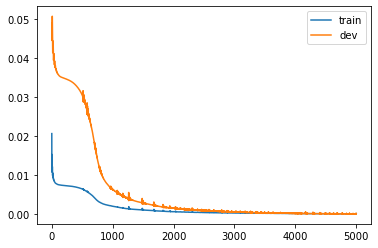

In [183]:
# design network
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(GRU(1))
# model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',  metrics=[tf.keras.metrics.RootMeanSquaredError()])
# fit network
#  
history = model.fit(train_X, train_y, epochs=5000, batch_size=1000, validation_data=(X_dev, y_dev), verbose=2, shuffle=False, callbacks=[model_checkpoint_callback])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()
plt.show()

In [184]:
# make a prediction
yhat = model.predict(test_X)
train_yhat = model.predict(train_X)

In [185]:
test_X = test_X.reshape((test_X.shape[0], n_months*n_features))
train_X = train_X.reshape((train_X.shape[0], n_months*n_features))

In [186]:
# invert scaling for forecast
inv_yhat_train = concatenate((train_yhat, train_X[:, -5:]), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,0]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_train = concatenate((train_y, train_X[:, -5:]), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:,0]

In [187]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [188]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
def month_to_year(month_preds):
    month_preds = month_preds[6:]
    year_preds = []
    for i in range(12, len(month_preds) + 1, 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The test root mean squared error is {}.".format(rmse))

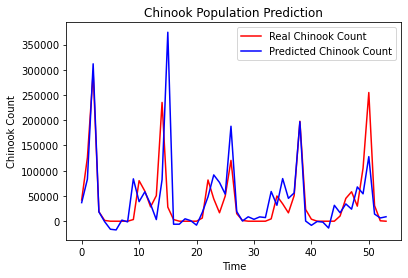

The test root mean squared error is 60721.38074846454.


In [189]:
plot_predictions(inv_y, inv_yhat)
return_rmse(inv_y, inv_yhat)

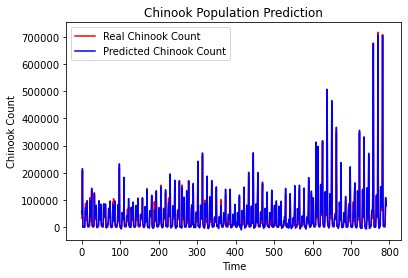

The test root mean squared error is 9861.972216549791.


In [190]:
plot_predictions(inv_y_train, inv_yhat_train)
return_rmse(inv_y_train, inv_yhat_train)

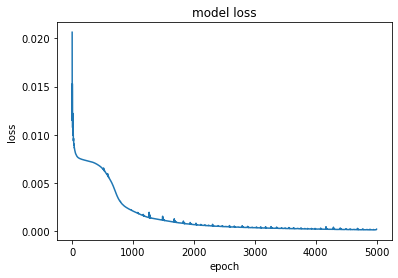

In [191]:
plot_loss(history)

In [192]:
preds = month_to_year(inv_yhat).astype(np.int64)
actual = month_to_year(inv_y).astype(np.int64)
print(preds)
print(actual)

    Count
0  646156
1  502435
2  484473
3  370624
    Count
0  488981
1  336030
2  381773
3  535746


In [193]:
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_ismael_path)
traditional = pd.DataFrame(baseline_data["Count"])
print(traditional)

    Count
0  498710
1  439060
2  294840
3  347600


In [194]:
return_rmse(actual, traditional)

The test root mean squared error is 115829.72216361394.


In [195]:
return_rmse(actual, preds)

The test root mean squared error is 150172.5420424786.
